In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
import seaborn as sns
import math
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score,log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold  
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

### Reading Gene and Variation Data

In [4]:
data = pd.read_csv('training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


### Reading Text Data

In [11]:
text = pd.read_csv('training/training_text',sep="\|\|",engine='python',names=['ID','TEXT'],skiprows=1)
print('No. of Data Points : ',text.shape[0])
print('No. of Features : ',text.shape[1])
text.head()

No. of Data Points :  3321
No. of Features :  2


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


### Preprocessing of text 

In [12]:
stop_words = set(stopwords.words('english'))
def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        ### Replace every special character with space
        total_text = re.sub('[^a-zA-Z0-9\n]',' ',total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        text[column][index] = string

In [14]:
#text processing stage.
start_time = time.clock()
for index, row in text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 639.7830354181128 seconds


In [15]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [74]:
#filling the null text data
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene']+' '+ str(result['ID'])  +' '+result['Variation'] 
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


### Splitting data into train, test and cross validation (64:20:16)

In [76]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [77]:
print(train_df.shape)
print(cv_df.shape)
print(test_df.shape)

print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

(2124, 5)
(532, 5)
(665, 5)
(2124,)
(532,)
(665,)


In [78]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sortlevel()
test_class_distribution = test_df['Class'].value_counts().sortlevel()
cv_class_distribution = cv_df['Class'].value_counts().sortlevel()

print("train class distribution:\n",train_class_distribution,"\n")
print("cv class distribution:\n",cv_class_distribution,"\n")
print("test class distribution:\n",test_class_distribution)

train class distribution:
 1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64 

cv class distribution:
 1     91
2     72
3     14
4    110
5     39
6     44
7    153
8      3
9      6
Name: Class, dtype: int64 

test class distribution:
 1    114
2     91
3     18
4    137
5     48
6     55
7    191
8      4
9      7
Name: Class, dtype: int64


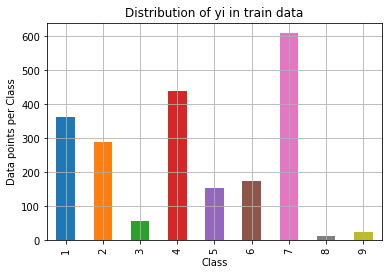

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


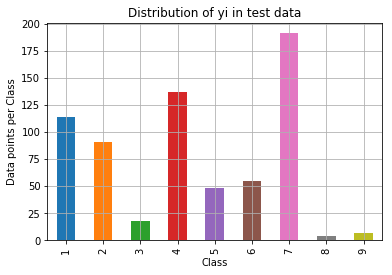

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


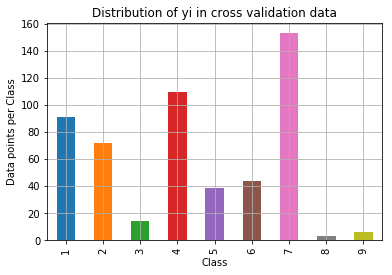

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [79]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sortlevel()
test_class_distribution = test_df['Class'].value_counts().sortlevel()
cv_class_distribution = cv_df['Class'].value_counts().sortlevel()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

### PDFs and CDFs 

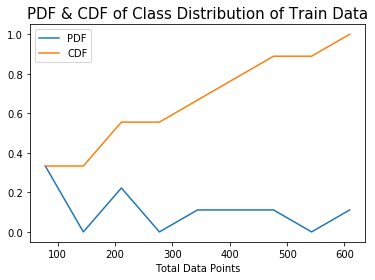

In [216]:
counts, bin_edges = np.histogram(train_class_distribution, bins=9, 
                                 density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:],pdf)
plt.plot(bin_edges[1:], cdf)

plt.xlabel('Total Data Points')
plt.title('PDF & CDF of Class Distribution of Train Data', size='15')
plt.gca().legend(('PDF','CDF'))

plt.show(); 

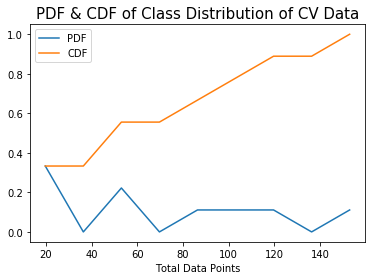

In [217]:
counts, bin_edges = np.histogram(cv_class_distribution, bins=9, 
                                 density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:],pdf)
plt.plot(bin_edges[1:], cdf)

plt.xlabel('Total Data Points')
plt.title('PDF & CDF of Class Distribution of CV Data', size='15')
plt.gca().legend(('PDF','CDF'))

plt.show(); 

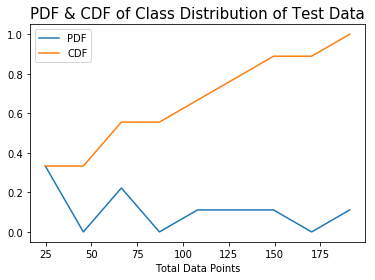

In [218]:
counts, bin_edges = np.histogram(test_class_distribution, bins=9, 
                                 density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:],pdf)
plt.plot(bin_edges[1:], cdf)

plt.xlabel('Total Data Points')
plt.title('PDF & CDF of Class Distribution of Test Data', size='15')
plt.gca().legend(('PDF','CDF'))

plt.show(); 

In [234]:
train_class_distribution_df = pd.DataFrame(train_class_distribution)
train_class_distribution_df.reset_index(level=0, inplace=True)

## Prediction using a 'Random' Model

In [95]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
        
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [80]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix C", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Train Data using Random Model 2.4626077277382987
Log loss on Cross Validation Data using Random Model 2.504215471251153
Log loss on Test Data using Random Model 2.489917832146807
Number of mis-classified points : 0.8857142857142857
-------------------- Confusion matrix --------------------


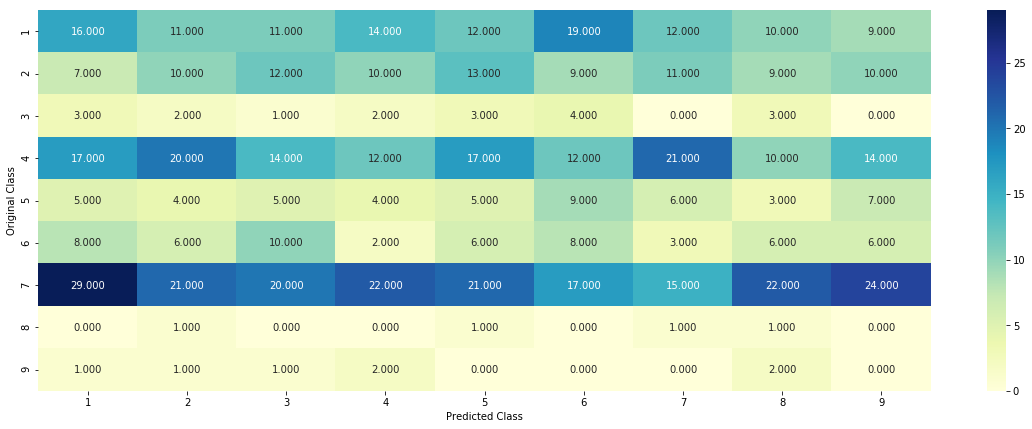

-------------------- Precision matrix (Columm Sum=1) --------------------


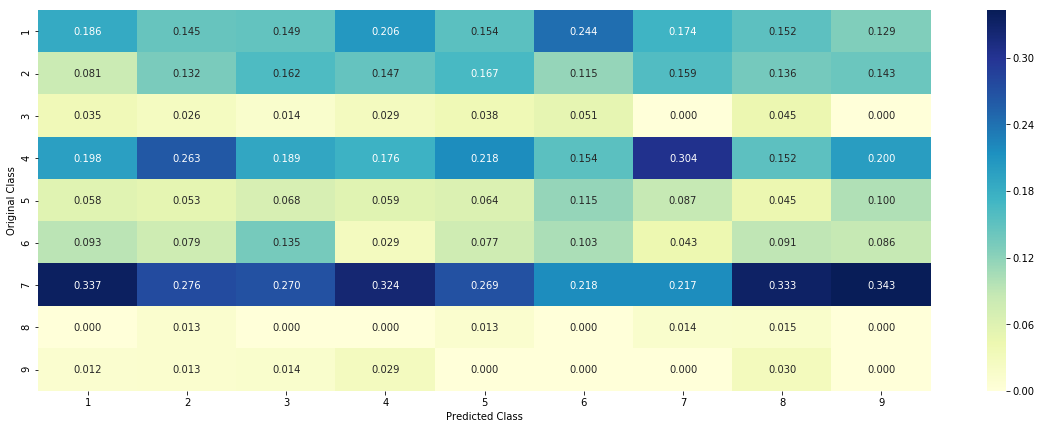

-------------------- Recall matrix (Row sum=1) --------------------


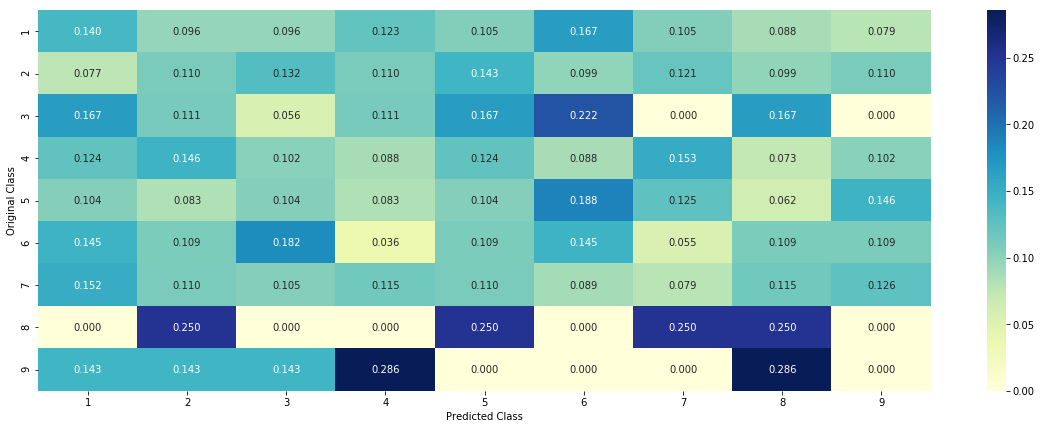

In [97]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
train_data_len = train_df.shape[0]
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the Train data
train_predicted_y = np.zeros((train_data_len,9))
for i in range(train_data_len):
    rand_probs = np.random.rand(1,9)
    train_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
log_loss_train_random = log_loss(y_train,train_predicted_y, eps=1e-15)
print("Log loss on Train Data using Random Model",log_loss_train_random)


# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
log_loss_cv_random = log_loss(y_cv,cv_predicted_y, eps=1e-15)
print("Log loss on Cross Validation Data using Random Model",log_loss_cv_random)


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
log_loss_test_random = log_loss(y_test,test_predicted_y, eps=1e-15)
print("Log loss on Test Data using Random Model",log_loss_test_random)


predicted_y =np.argmax(test_predicted_y, axis=1) #converting probabilities into class level
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((predicted_y- test_y))/test_y.shape[0])
plot_confusion_matrix(y_test, predicted_y+1)

#### Observation:

Random model has been taken as baseline model.

And the random model got log loss of 2.48 for test data

### Univariate Analysis on 'Gene' feature

In [81]:
def get_gv_fea_dict(alpha, feature, df):
    
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
        #print(gv_dict)
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [82]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 238
BRCA1     163
TP53      107
EGFR       87
PTEN       84
BRCA2      75
BRAF       65
KIT        56
ALK        45
PDGFRA     39
ERBB2      37
Name: Gene, dtype: int64


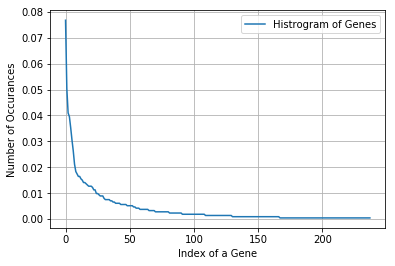

In [98]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

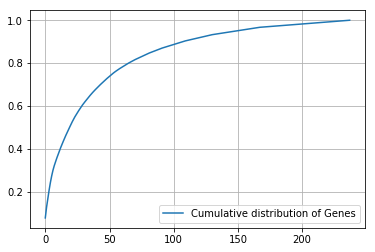

In [99]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [136]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [83]:
# bigrams.
gene_vectorizer_bigram = CountVectorizer(ngram_range=(1,2))
train_gene_feature_bigram = gene_vectorizer_bigram.fit_transform(train_df['Gene'])
test_gene_feature_bigram = gene_vectorizer_bigram.transform(test_df['Gene'])
cv_gene_feature_bigram = gene_vectorizer_bigram.transform(cv_df['Gene'])


#  Tf-idf encoding  
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
train_gene_tfidf = tfidf_vect.fit_transform(train_df['Gene'])
test_gene_tfidf = tfidf_vect.transform(test_df['Gene'])
cv_gene_tfidf = tfidf_vect.transform(cv_df['Gene'])

In [101]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [102]:
train_df['Gene'].head()

2588     BRCA1
1465     FGFR2
1185    PIK3CA
960      KDM5C
14         CBL
Name: Gene, dtype: object

In [103]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_tfidf.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 237)


In [104]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 237)


In [105]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'axin1',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',

## Logistic Regression on Gene Feature

For values of alpha =  1e-05 The log loss is: 1.3686957852659927
For values of alpha =  0.0001 The log loss is: 1.1963352658106332
For values of alpha =  0.001 The log loss is: 1.2051843630253987
For values of alpha =  0.01 The log loss is: 1.3108570481603103
For values of alpha =  0.1 The log loss is: 1.414502704459861
For values of alpha =  1 The log loss is: 1.4503323173431266


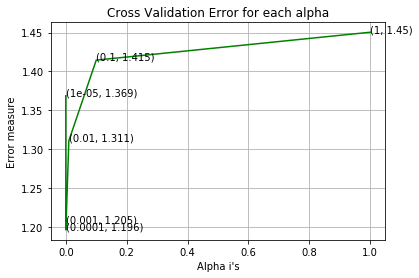

For values of best alpha =  0.0001 The train log loss is: 1.0252136649004921
For values of best alpha =  0.0001 The cross validation log loss is: 1.1963352658106332
For values of best alpha =  0.0001 The test log loss is: 1.216614607567022
Number of mis-classified points : 0.9428571428571428


In [106]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y =np.argmax(predict_y, axis=1) #converting probabilities into class level
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((predicted_y- test_y))/test_y.shape[0])

In [107]:
print("Following number of Data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Following number of Data points in Test and CV datasets are covered by the  238  genes in train dataset

1. In test data 646 out of 665 : 97.14285714285714
2. In cross validation data 521 out of  532 : 97.93233082706767


#### T- SNE on Gene Feature

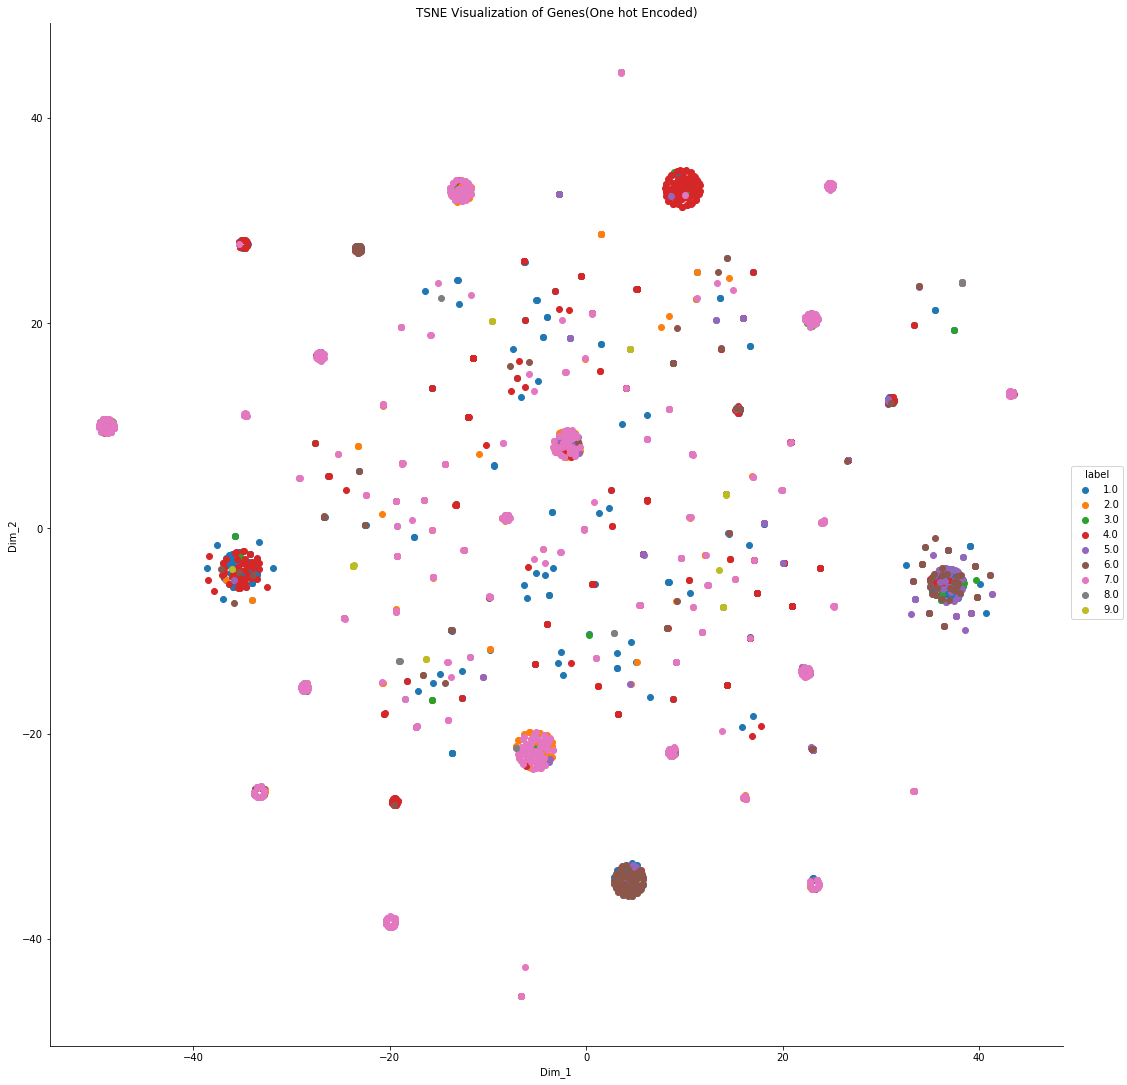

In [108]:
data_points = train_gene_feature_onehotCoding
top_1000 = data_points.toarray()
top_labels = y_train
model = TSNE(n_components=2,random_state=0)
tsne_data = model.fit_transform(top_1000)
tsne_data = np.vstack((tsne_data.T,top_labels.T)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=('Dim_1','Dim_2','label'))
sns.FacetGrid(data=tsne_df,hue='label',size=15).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('TSNE Visualization of Genes(One hot Encoded)')
plt.show()

### Univariate Analysis on 'Variation' feature 

In [84]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1936
Truncating_Mutations    61
Deletion                50
Amplification           37
Fusions                 20
Overexpression           4
G12V                     3
E17K                     3
E542K                    2
A146T                    2
S222D                    2
Name: Variation, dtype: int64


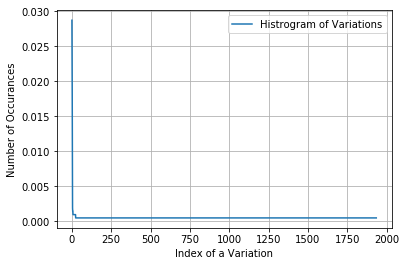

In [109]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.0287194  0.05225989 0.06967985 ... 0.99905838 0.99952919 1.        ]


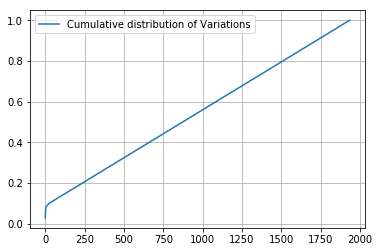

In [110]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [111]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [85]:
# unigrams and bigrams
variation_vectorizer_bigram = CountVectorizer(ngram_range=(1,2))
train_variation_feature_bigram = variation_vectorizer_bigram.fit_transform(train_df['Variation'])
test_variation_feature_bigram = variation_vectorizer_bigram.transform(test_df['Variation'])
cv_variation_feature_bigram = variation_vectorizer_bigram.transform(cv_df['Variation'])

# tfidf vectorized
tfidf_vect = TfidfVectorizer()
train_variation_feature_tfidf = tfidf_vect.fit_transform(train_df['Variation'])
test_variation_feature_tfidf = tfidf_vect.transform(test_df['Variation'])
cv_variation_feature_tfidf = tfidf_vect.transform(cv_df['Variation'])

In [112]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [ ]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

In [ ]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

### Logistic Regression on Variation Feature

For values of alpha =  1e-05 The log loss is: 1.740469509247296
For values of alpha =  0.0001 The log loss is: 1.7322365300209561
For values of alpha =  0.001 The log loss is: 1.740381690633717
For values of alpha =  0.01 The log loss is: 1.760827962698529
For values of alpha =  0.1 The log loss is: 1.7761354554701074
For values of alpha =  1 The log loss is: 1.7765586507260158


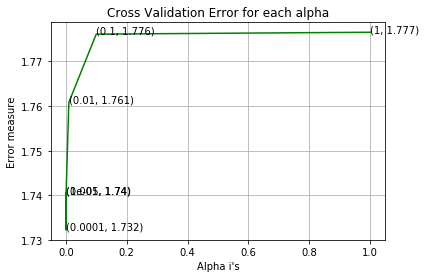

For values of best alpha =  0.0001 The train log loss is: 0.7111023558122576
For values of best alpha =  0.0001 The cross validation log loss is: 1.7322365300209561
For values of best alpha =  0.0001 The test log loss is: 1.6934299709367888
Number of mis-classified points : 0.9142857142857143


In [113]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y =np.argmax(predict_y, axis=1) #converting probabilities into class level
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((predicted_y- test_y))/test_y.shape[0])

In [114]:
print("The number of data points covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets are")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

The number of data points covered by total  1936  genes in test and cross validation data sets are

1. In test data 76 out of 665 : 11.428571428571429
2. In cross validation data 56 out of  532 : 10.526315789473683


### T-SNE on Variation Feature 

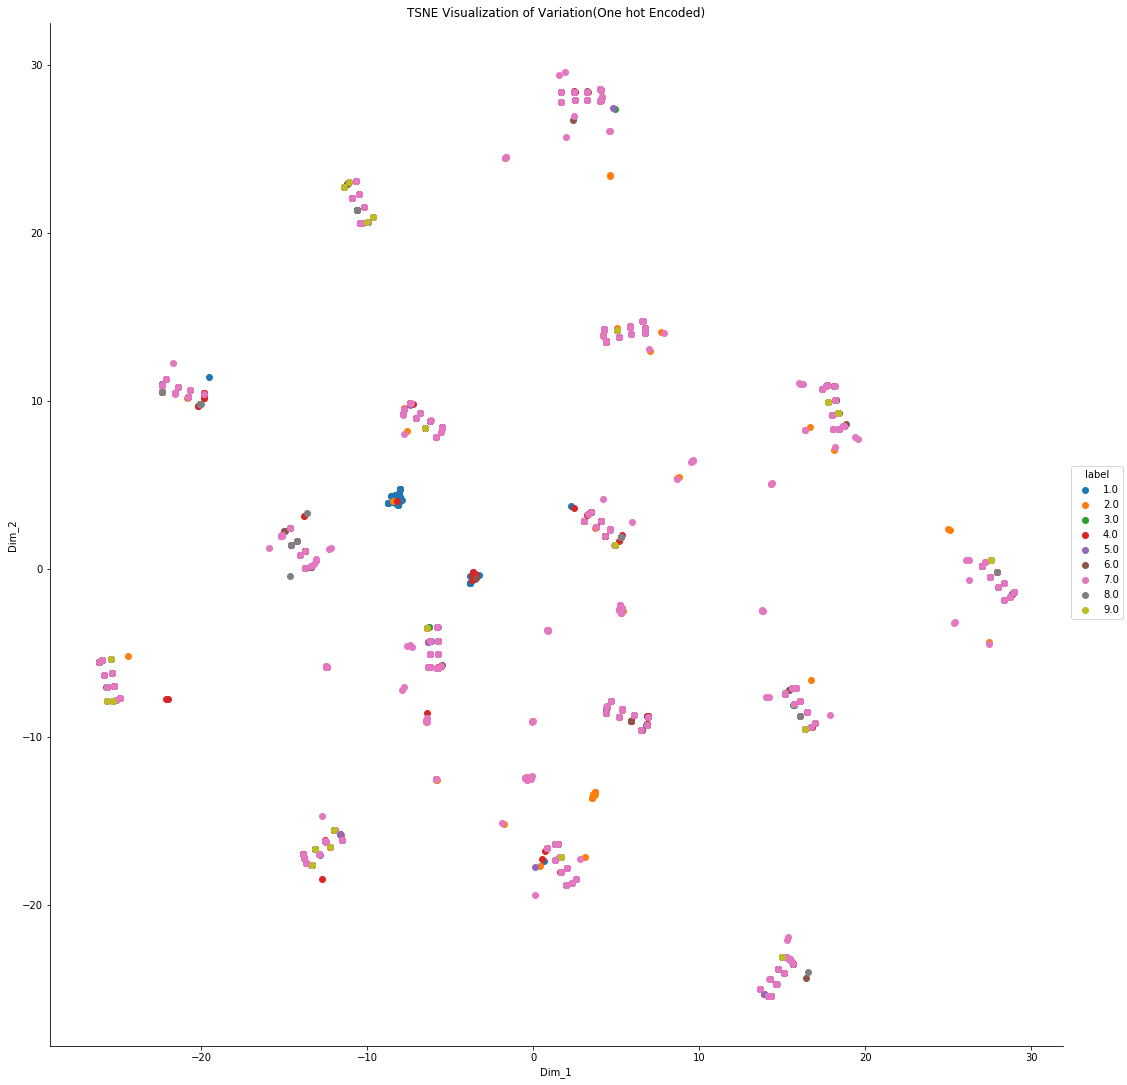

In [115]:
data_points = train_variation_feature_onehotCoding
top_1000 = data_points.toarray()
top_labels = y_train
model = TSNE(n_components=2,random_state=0)
tsne_data = model.fit_transform(top_1000)
tsne_data = np.vstack((tsne_data.T,top_labels.T)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=('Dim_1','Dim_2','label'))
sns.FacetGrid(data=tsne_df,hue='label',size=15).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('TSNE Visualization of Variation(One hot Encoded)')
plt.show()

### Univariate Analysis on Text Feature 

In [116]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [117]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [118]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data

text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52219


In [88]:
#  unigrams and bigrams
text_vectorizer_bigram = CountVectorizer(ngram_range=(1,2))
train_text_feature_bigram = normalize(text_vectorizer_bigram.fit_transform(train_df['TEXT']))
test_text_feature_bigram = normalize(text_vectorizer_bigram.transform(test_df['TEXT']))
cv_text_feature_bigram = normalize(text_vectorizer_bigram.transform(cv_df['TEXT']))


#  tfidf vectorization
tfidf_text_vect = TfidfVectorizer(ngram_range=(1,2))
train_text_vect = tfidf_text_vect.fit_transform(train_df['TEXT'])
cross_val_text_vect = tfidf_text_vect.transform(cv_df['TEXT'])
test_text_vect = tfidf_text_vect.transform(test_df['TEXT'])

In [119]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [120]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [121]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [122]:
# normalizing every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [123]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [124]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 4734, 4: 3531, 5: 2879, 6: 2690, 8: 2179, 7: 1890, 9: 1751, 12: 1539, 11: 1359, 10: 1297, 13: 923, 15: 801, 14: 773, 16: 756, 18: 718, 17: 616, 19: 596, 22: 566, 20: 564, 21: 513, 24: 505, 23: 407, 25: 399, 26: 390, 40: 377, 30: 339, 27: 326, 28: 322, 34: 314, 32: 291, 36: 287, 45: 286, 29: 284, 33: 234, 35: 229, 39: 224, 46: 221, 42: 221, 38: 221, 31: 213, 44: 202, 48: 197, 54: 188, 37: 188, 41: 172, 49: 165, 47: 153, 43: 146, 53: 141, 57: 139, 50: 139, 65: 132, 51: 130, 64: 129, 56: 128, 55: 127, 52: 125, 58: 121, 60: 119, 66: 109, 63: 107, 68: 104, 59: 104, 72: 102, 62: 102, 70: 101, 61: 98, 69: 95, 67: 95, 88: 87, 75: 86, 74: 85, 80: 84, 78: 79, 92: 78, 84: 78, 77: 78, 85: 77, 76: 75, 71: 75, 90: 74, 79: 74, 86: 73, 82: 73, 81: 73, 94: 72, 102: 71, 73: 69, 96: 68, 112: 64, 97: 62, 103: 61, 106: 60, 87: 60, 83: 60, 104: 59, 99: 56, 100: 55, 93: 54, 110: 53, 91: 53, 89: 52, 114: 47, 125: 46, 122: 46, 111: 45, 109: 45, 138: 44, 134: 44, 130: 44, 108: 44, 98: 44, 141: 43, 1

## Logistic Regression on Text Feature (One-Hot Encoded) 

For values of alpha =  1e-05 The log loss is: 1.3295079600575332
For values of alpha =  0.0001 The log loss is: 1.2761254756442793
For values of alpha =  0.001 The log loss is: 1.1870662728628807
For values of alpha =  0.01 The log loss is: 1.2454410813401862
For values of alpha =  0.1 The log loss is: 1.439887318379843
For values of alpha =  1 The log loss is: 1.672749246395518


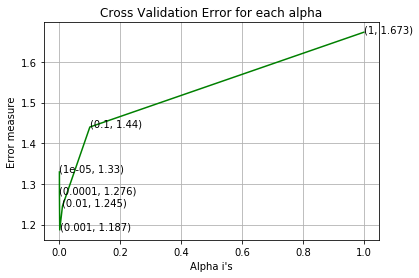

For values of best alpha =  0.001 The train log loss is: 0.7001371701802732
For values of best alpha =  0.001 The cross validation log loss is: 1.1870662728628807
For values of best alpha =  0.001 The test log loss is: 1.1973329448493666
Number of mis-classified points : 0.968421052631579


In [125]:
# Train a Logistic regression + Calibration model using text features which are on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


predicted_y =np.argmax(predict_y, axis=1) #converting probabilities into class level
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((predicted_y- test_y))/test_y.shape[0])

In [126]:
def get_intersec_text(df):
    df_text_vec = TfidfVectorizer(min_df=3, ngram_range=(1,2), max_features=1000)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [127]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

93.9 % of word of test data appeared in train data
93.3 % of word of Cross Validation appeared in train data


### T-SNE on Text Feature (onehotCoding - Train Data)

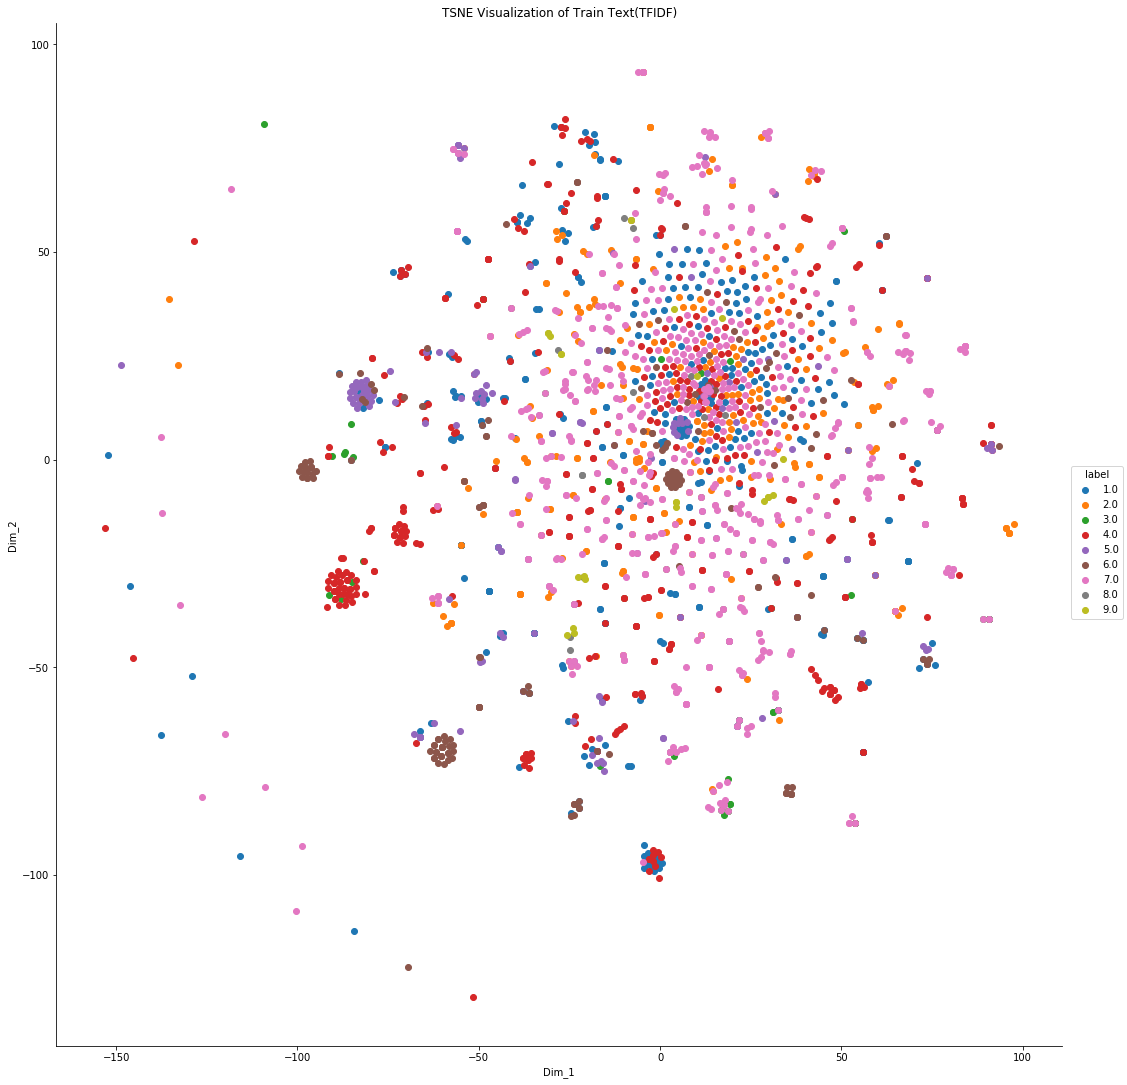

In [199]:
data_points = train_text_feature_onehotCoding
top_1000 = data_points.toarray()
top_labels = y_train
model = TSNE(n_components=2,random_state=0)
tsne_data = model.fit_transform(top_1000)
tsne_data = np.vstack((tsne_data.T,top_labels.T)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=('Dim_1','Dim_2','label'))
sns.FacetGrid(data=tsne_df,hue='label',size=15).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('TSNE Visualization of Train Text(TFIDF)')
plt.show()

In [198]:
print(type(train_text_feature_onehotCoding))
print(np.shape(train_text_feature_onehotCoding))

<class 'scipy.sparse.csr.csr_matrix'>
(2124, 2353720)


## Machine Learning Models 

In [131]:
#Data preparation for ML models.

#Misc. functionns for ML models

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)
    
    
    
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)



# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer(min_df=3, ngram_range=(1,2), max_features=1000)
    var_count_vec = TfidfVectorizer(min_df=3, ngram_range=(1,2), max_features=1000)
    text_count_vec = TfidfVectorizer(min_df=3, ngram_range=(1,2), max_features=1000)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

### Stacking the three types of features 

In [137]:
# merging gene, variance and text features

# building train, test and cross validation data sets

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()


###  Response Coding  ###

train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [89]:
###  Tfidf ###

train_gene_var_tfidf = hstack((train_gene_tfidf,train_variation_feature_tfidf))
test_gene_var_tfidf = hstack((test_gene_tfidf,test_variation_feature_tfidf))
cv_gene_var_tfidf = hstack((cv_gene_tfidf,cv_variation_feature_tfidf))

train_x_tfidf = hstack((train_gene_var_tfidf,train_text_vect)).tocsr()
test_x_tfidf = hstack((test_gene_var_tfidf,test_text_vect)).tocsr()
cv_x_tfidf = hstack((cv_gene_var_tfidf,cross_val_text_vect)).tocsr()

###  Unigrams and bigrams   ####

train_gene_var_bigram = hstack((train_gene_feature_bigram,train_variation_feature_bigram))
test_gene_var_bigram = hstack((test_gene_feature_bigram,test_variation_feature_bigram))
cv_gene_var_bigram = hstack((cv_gene_feature_bigram,cv_variation_feature_bigram))

train_x_bigram = hstack((train_gene_var_bigram, train_text_feature_bigram)).tocsr()
test_x_bigram = hstack((test_gene_var_bigram, test_text_feature_bigram)).tocsr()
cv_x_bigram = hstack((cv_gene_var_bigram, cv_text_feature_bigram)).tocsr()


train_y = np.array(list(train_df['Class']))
test_y = np.array(list(test_df['Class']))
cv_y = np.array(list(cv_df['Class']))

In [138]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 54421)
(number of data points * number of features) in test data =  (665, 54421)
(number of data points * number of features) in cross validation data = (532, 54421)


In [139]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## Naive Bayes 


for alpha = 0.0001
CV Log Loss : 1.2921309674329147

for alpha = 0.001
CV Log Loss : 1.29016236330165

for alpha = 0.1
CV Log Loss : 1.2969459486450912

for alpha = 1
CV Log Loss : 1.2679414209037072

for alpha = 10
CV Log Loss : 1.319450270950134

for alpha = 100
CV Log Loss : 1.3486586365221767


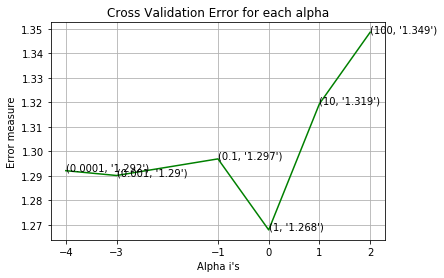

For values of best alpha =  1 The train log loss is: 0.9151887243795561
For values of best alpha =  1 The cross validation log loss is: 1.2679414209037072
For values of best alpha =  1 The test log loss is: 1.2949910047717403


In [140]:
#Hyperparameter tuning

alpha = [0.0001, 0.001, 0.1, 1, 10, 100]
cv_log_error_array = []
for i in alpha:
    print("\nfor alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("CV Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.2679414209037072
Number of missclassified point : 0.3815789473684211
-------------------- Confusion matrix --------------------


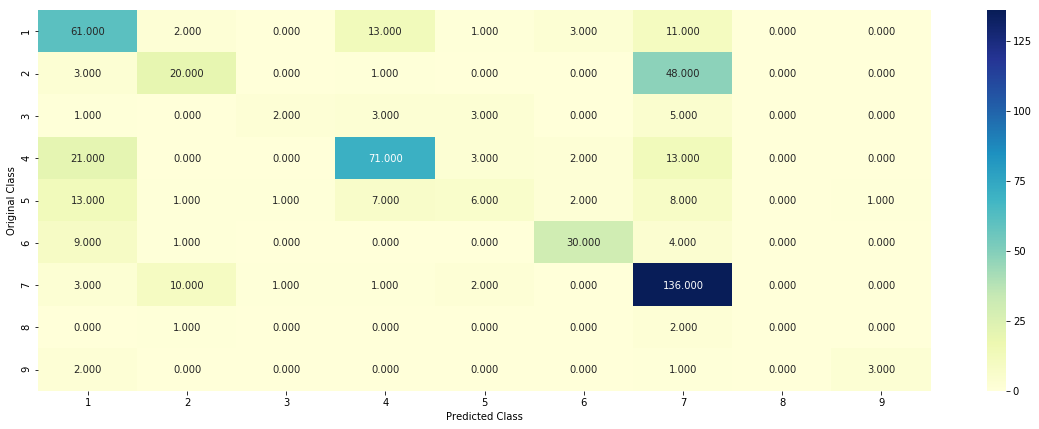

-------------------- Precision matrix (Columm Sum=1) --------------------


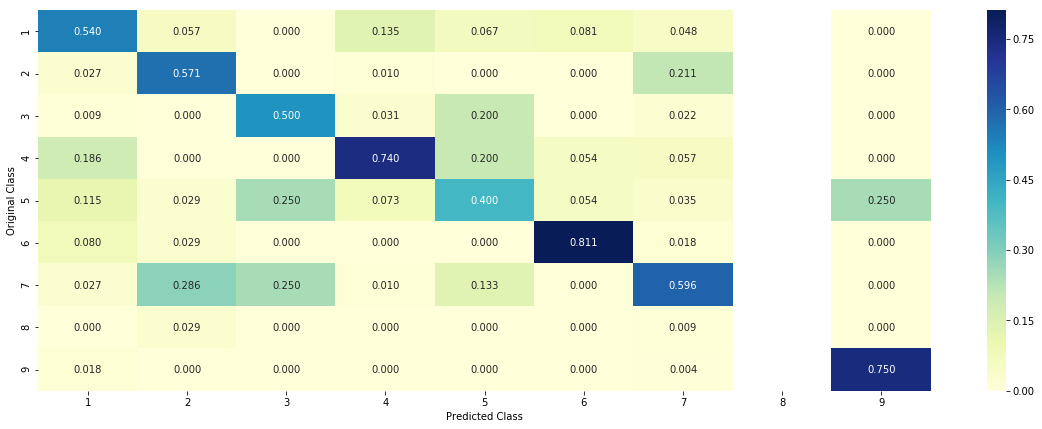

-------------------- Recall matrix (Row sum=1) --------------------


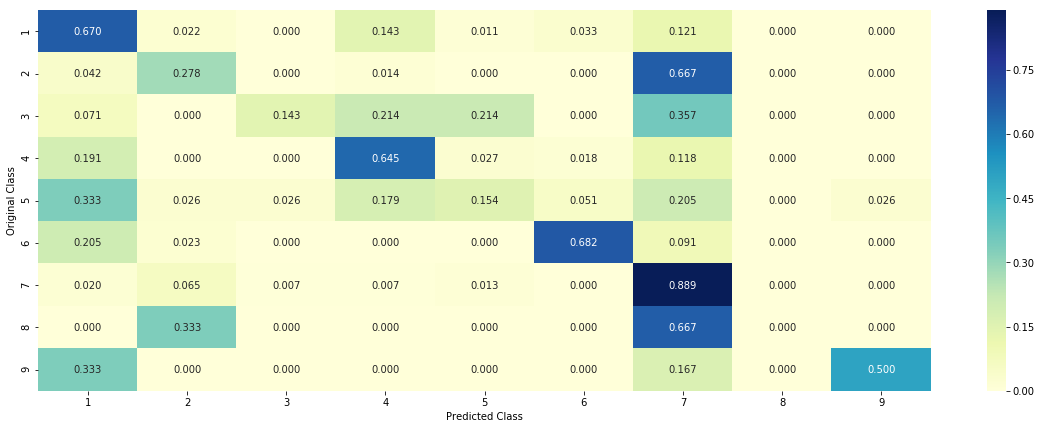

In [141]:
#Testing the model with best hyper paramters

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

#### Observation:

For onehotencoding the naive-bayes model has been applied above.

It resulted in 0.91 log-loss for training-set, 1.26 log-loss for CV data and 1.29 for test-set.

In [142]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
#get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0648 0.0839 0.023  0.0893 0.0512 0.0389 0.6396 0.0057 0.0036]]
Actual Class : 7
--------------------------------------------------


In [145]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
#get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.435  0.095  0.0259 0.1008 0.2181 0.044  0.0707 0.0064 0.004 ]]
Actual Class : 5
--------------------------------------------------


## K Nearest Neighbour Classification 


for alpha = 5
Log Loss : 1.1086667120337175

for alpha = 11
Log Loss : 1.0977994446267154

for alpha = 15
Log Loss : 1.0925676027867914

for alpha = 21
Log Loss : 1.0977991857377531

for alpha = 31
Log Loss : 1.1088110925084231

for alpha = 41
Log Loss : 1.1162383332314791

for alpha = 51
Log Loss : 1.1177291411318142

for alpha = 99
Log Loss : 1.1218199380965272


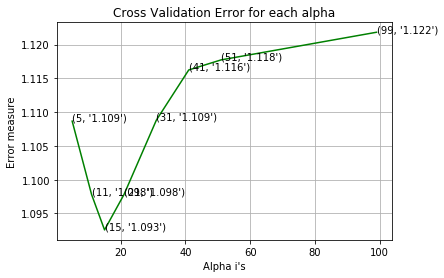

For values of best alpha =  15 The train log loss is: 0.6838789439284688
For values of best alpha =  15 The cross validation log loss is: 1.0925676027867914
For values of best alpha =  15 The test log loss is: 1.1145938485283275


In [146]:
#Hyper parameter tuning

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("\nfor alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.0925676027867914
Number of mis-classified points : 0.37593984962406013
-------------------- Confusion matrix --------------------


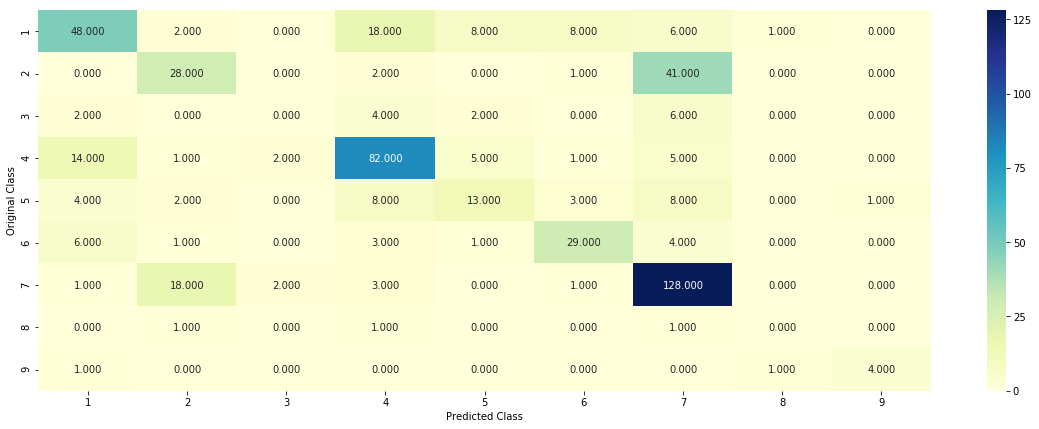

-------------------- Precision matrix (Columm Sum=1) --------------------


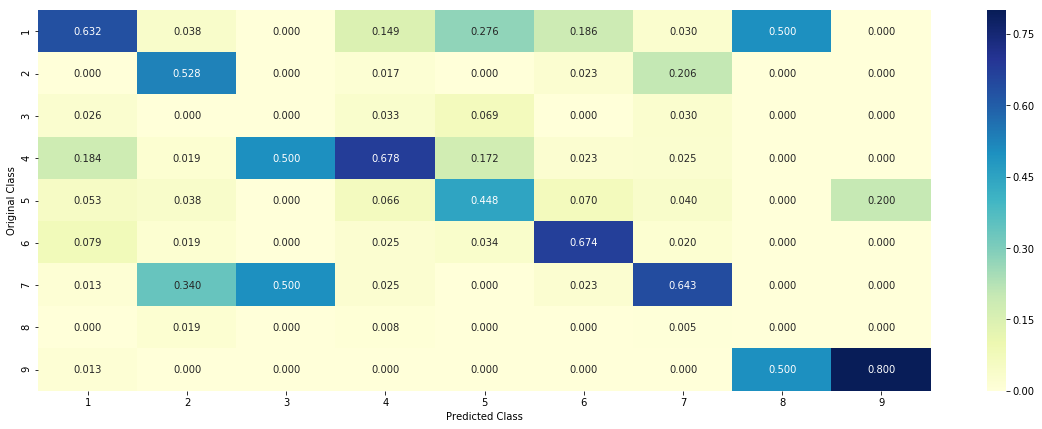

-------------------- Recall matrix (Row sum=1) --------------------


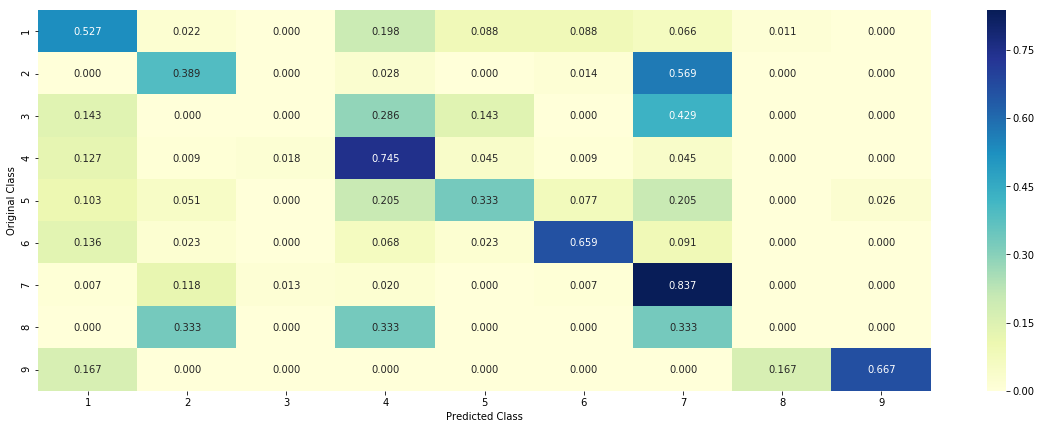

In [147]:
#Testing the model with best hyper paramters

clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

#### Observation:

For responseCoding the KNN model has been applied above.

It resulted in 0.68 log-loss for training-set, 1.09 log-loss for CV data and 1.11 for test-set. 

But classes, with less number of values, have suffered as they are not involved in precision and recall matrix.

Results are better than Naive Bayes model. 

In [148]:
#Sample Query point 1

clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
The  15  nearest neighbours of the test points belongs to classes [7 7 7 7 7 7 2 2 7 7 7 7 7 7 7]
Fequency of nearest points : Counter({7: 13, 2: 2})


In [149]:
#Sample Query point 2

clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 6
Actual Class : 5
the k value for knn is 15 and the nearest neighbours of the test points belongs to classes [1 1 5 5 1 1 6 6 5 5 1 1 6 6 6]
Fequency of nearest points : Counter({1: 6, 6: 5, 5: 4})


## Logistic Regression on BoW (Uni- & Bi-grams) with Class Balanced


for C = 0.01
Log Loss : 1.262196180278021

for C = 0.1
Log Loss : 1.1390290756935944

for C = 1
Log Loss : 1.0310934117001407

for C = 10
Log Loss : 0.987648923314635

for C = 100
Log Loss : 0.9820765457740601


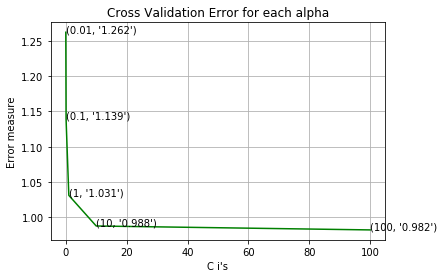

For values of best alpha =  100 The train log loss is: 0.3533032245749473
For values of best alpha =  100 The cross validation log loss is: 0.9820765457740601
For values of best alpha =  100 The test log loss is: 0.9626411888138315


In [129]:
### unibrams and bigrams with class balancing 

from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-2, 3)]
cv_log_error_array = []
for i in alpha:
    print("\nfor C =", i)
    clf = LogisticRegression(class_weight='balanced', C=i, penalty='l2', random_state=42)
    clf.fit(train_x_bigram, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_bigram, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_bigram)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(class_weight='balanced', C=alpha[best_alpha], penalty='l2', random_state=42)
clf.fit(train_x_bigram, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_bigram, train_y)

predict_y = sig_clf.predict_proba(train_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

Log loss : 0.9820765457740601
Number of mis-classified points : 0.325187969924812
-------------------- Confusion matrix --------------------


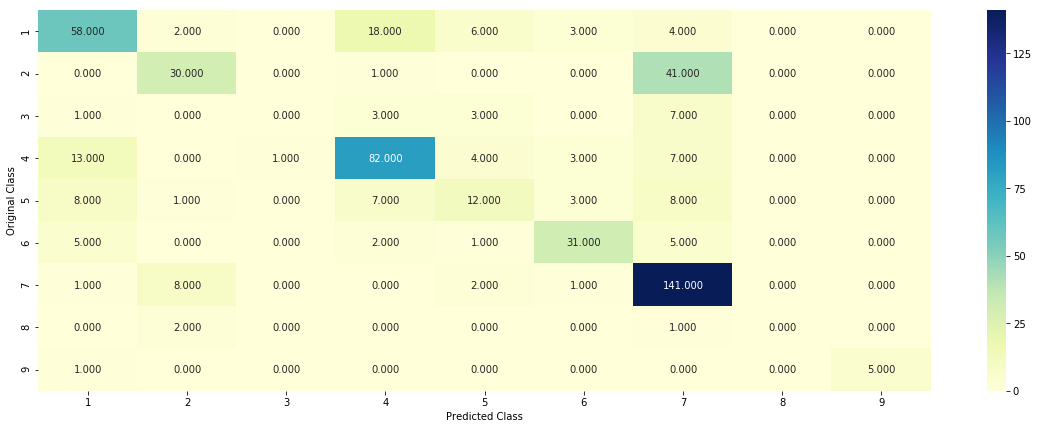

-------------------- Precision matrix (Columm Sum=1) --------------------


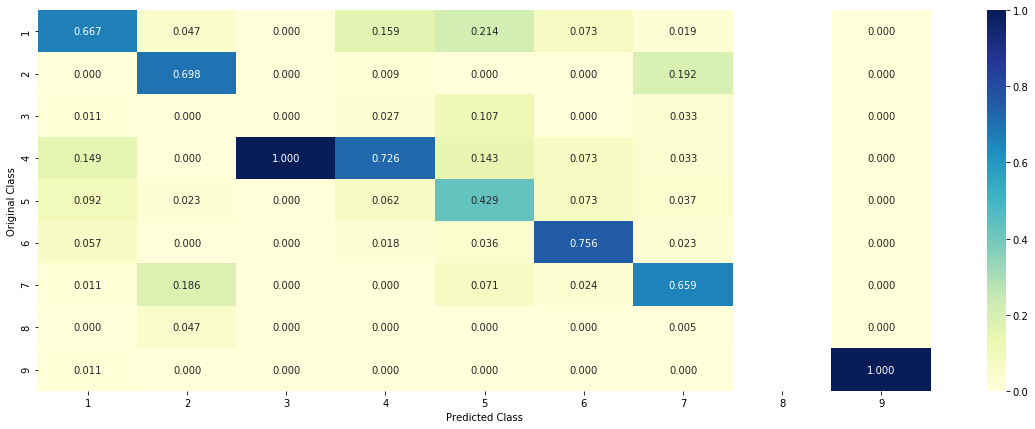

-------------------- Recall matrix (Row sum=1) --------------------


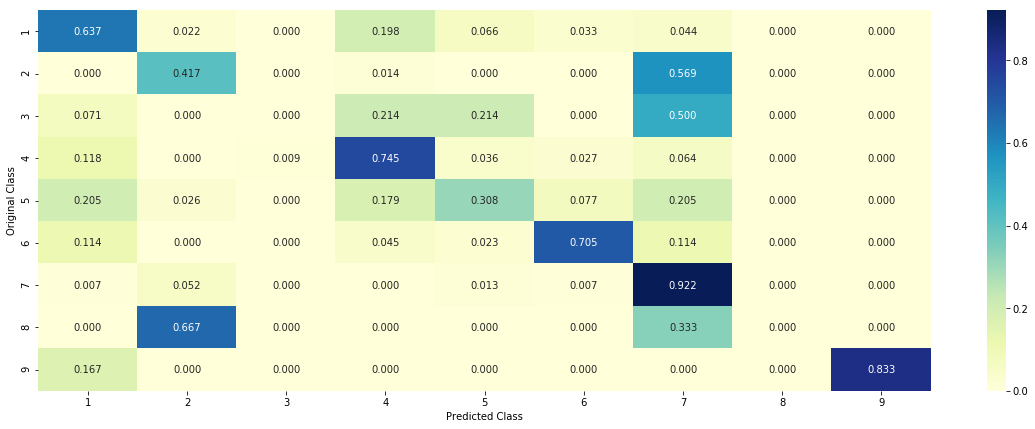

In [132]:
#Testing the model with best hyper paramters

clf = LogisticRegression(class_weight='balanced', C=alpha[best_alpha], penalty='l2', random_state=42)
predict_and_plot_confusion_matrix(train_x_bigram, y_train, cv_x_bigram, y_cv, clf)

#### Observation:

For BoW, the Logistic Regression model has been applied above, with balanced class.

It resulted in 0.35 log-loss for training-set, 0.98 log-loss for CV data and 0.96 for test-set. 

But classes, with less number of values, have suffered as they are not involved in precision and recall matrix.

Results are better than Naive Bayes or KNN model.  

### Logistic Regression on BoW (Uni- & Bi-grams) without Class Balanced 


for C = 0.1
Log Loss : 1.1348167563582479

for C = 1
Log Loss : 1.021907198802187

for C = 10
Log Loss : 0.9862176013808326

for C = 100
Log Loss : 0.9824376470582592


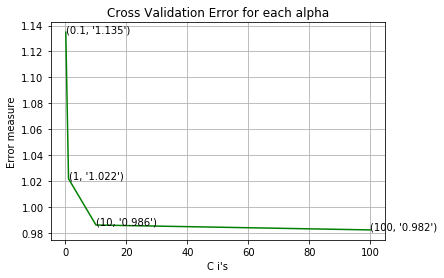

For values of best alpha =  100 The train log loss is: 0.3522104206219732
For values of best alpha =  100 The cross validation log loss is: 0.9824376470582592
For values of best alpha =  100 The test log loss is: 0.9633440215559156


In [94]:
### countvecterizor: unigram and bigram without class balancing ###

from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-1, 3)]
cv_log_error_array = []
for i in alpha:
    print("\nfor C =", i)
    clf = LogisticRegression(C=i, penalty='l2', random_state=42)
    clf.fit(train_x_bigram, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_bigram, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_bigram)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(C=alpha[best_alpha], penalty='l2', random_state=42)
clf.fit(train_x_bigram, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_bigram, y_train)

predict_y = sig_clf.predict_proba(train_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

Log loss : 0.9824376470582592
Number of mis-classified points : 0.325187969924812
-------------------- Confusion matrix --------------------


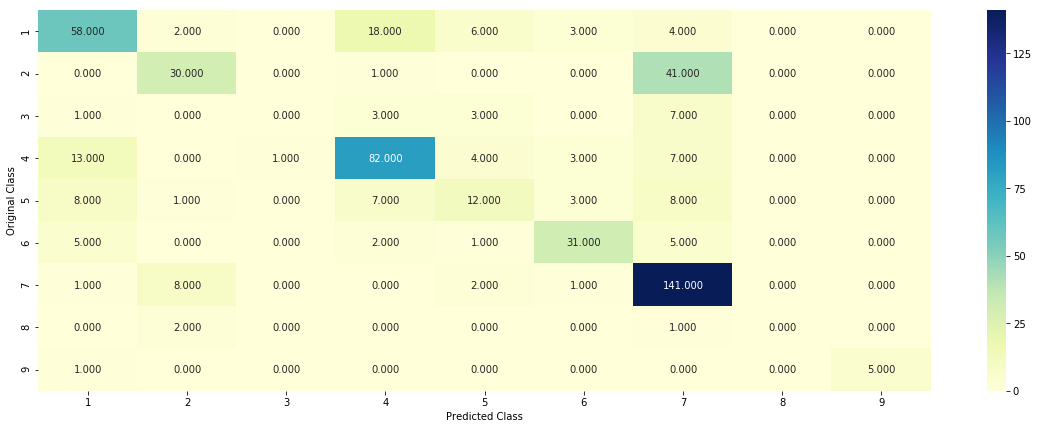

-------------------- Precision matrix (Columm Sum=1) --------------------


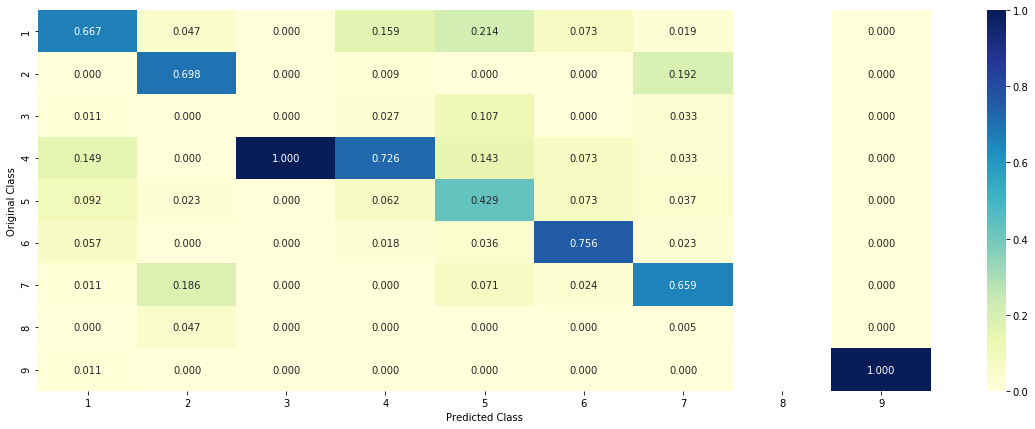

-------------------- Recall matrix (Row sum=1) --------------------


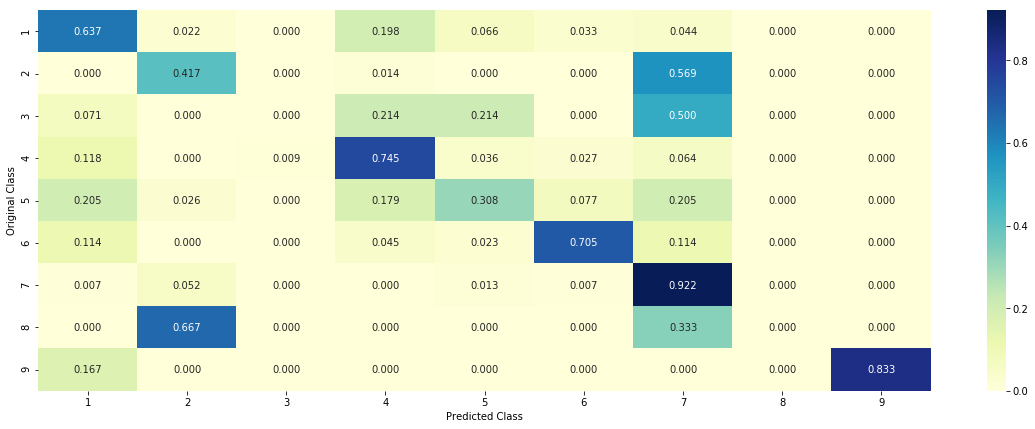

In [133]:
#Testing the model with best hyper paramters

clf = LogisticRegression(C=alpha[best_alpha], penalty='l2', random_state=42)
predict_and_plot_confusion_matrix(train_x_bigram, y_train, cv_x_bigram, y_cv, clf)

#### Observation:

For BoW, the Logistic Regression model has been applied above, without balanced class.

It resulted in 0.35 log-loss for training-set, 0.98 log-loss for CV data and 0.96 for test-set. 

But classes, with less number of values, have suffered as they are not involved in precision and recall matrix.

Results are better than Naive Bayes or KNN model and equivalent to balanced class case.   

## Logistic Regression on tfidf (Uni- & Bi-grams) with Class Balanced


for C = 0.001
Log Loss : 1.3622926669356896

for C = 0.01
Log Loss : 1.224137814908629

for C = 0.1
Log Loss : 1.1411279235978273

for C = 1
Log Loss : 1.0280986202080138

for C = 10
Log Loss : 0.9837971748431439

for C = 100
Log Loss : 0.9790087470396699


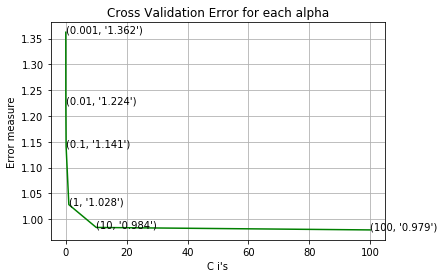

For values of best alpha =  100 The train log loss is: 0.35301532769444927
For values of best alpha =  100 The cross validation log loss is: 0.9790087470396699
For values of best alpha =  100 The test log loss is: 0.961787335809495


In [150]:
### tfidf: unigram and bigram with class balancing####

from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-3, 3)]
cv_log_error_array = []
for i in alpha:
    print("\nfor C =", i)
    clf = LogisticRegression(class_weight='balanced', C=i, penalty='l2', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(class_weight='balanced', C=alpha[best_alpha], penalty='l2', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

Log loss : 0.9790087470396699
Number of mis-classified points : 0.32142857142857145
-------------------- Confusion matrix --------------------


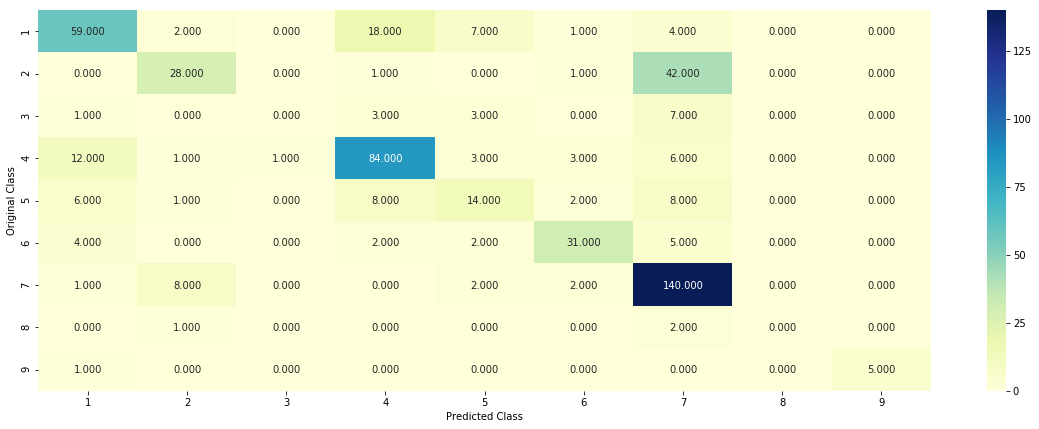

-------------------- Precision matrix (Columm Sum=1) --------------------


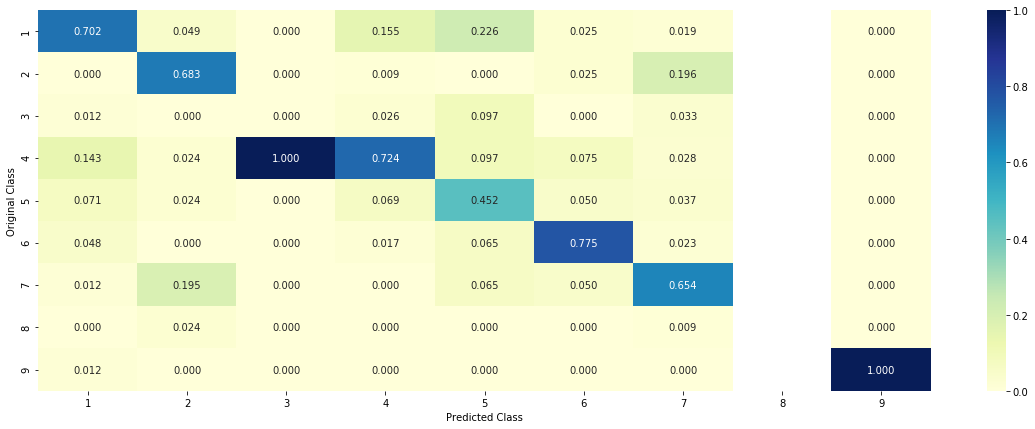

-------------------- Recall matrix (Row sum=1) --------------------


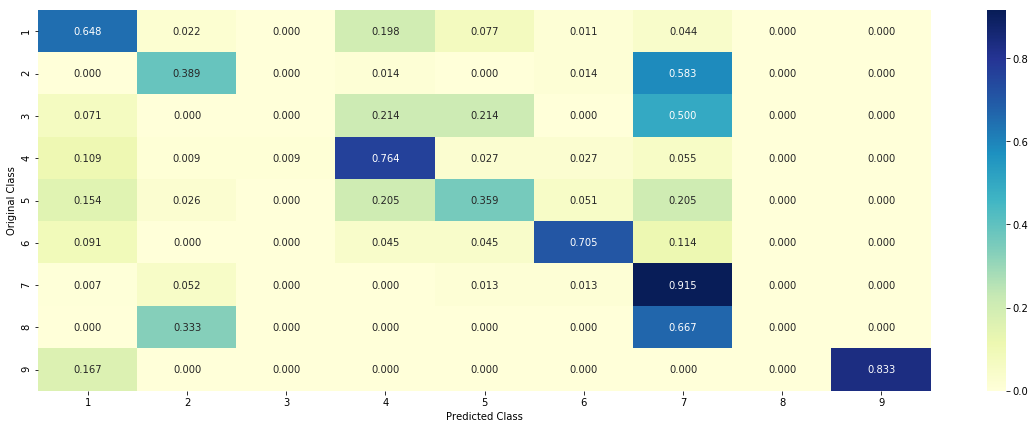

In [151]:
#Testing the model with best hyper paramters

clf = LogisticRegression(class_weight='balanced', C=alpha[best_alpha], penalty='l2', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf, y_train, cv_x_tfidf, y_cv, clf)

#### Observation:

For tfidf (unigram and bigram with class balancing), the Logistic model has been applied above.

It resulted in 0.35 log-loss for training-set, 0.98 log-loss for CV data and 0.96 for test-set. 

But classes, with less number of values, have suffered again as they are not involved in precision and recall matrix.

Results are better than Naive Bayed or KNN model and equivalent to Logistic Regression with BoW.

### Logistic Regression (tfidf: unigram and bigram without class balancing)

for C = 0.001
Log Loss : 1.3362736717959678
for C = 0.01
Log Loss : 1.221145452773555
for C = 0.1
Log Loss : 1.1303585161278564
for C = 1
Log Loss : 1.0170405100054671
for C = 10
Log Loss : 0.9824220536602879
for C = 100
Log Loss : 0.9792653584067594


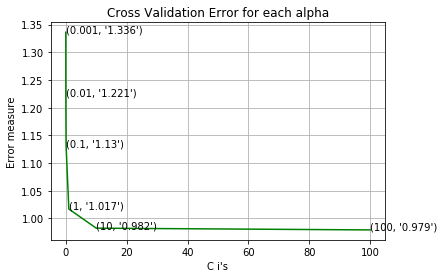

For values of best alpha =  100 The train log loss is: 0.35211357449668595
For values of best alpha =  100 The cross validation log loss is: 0.9792653584067594
For values of best alpha =  100 The test log loss is: 0.962320744265082


In [152]:
### tfidf: unigram and bigram without class balancing ###

from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-3, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = LogisticRegression(C=i, penalty='l2', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(C=alpha[best_alpha], penalty='l2', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

Log loss : 0.9792653584067594
Number of mis-classified points : 0.31954887218045114
-------------------- Confusion matrix --------------------


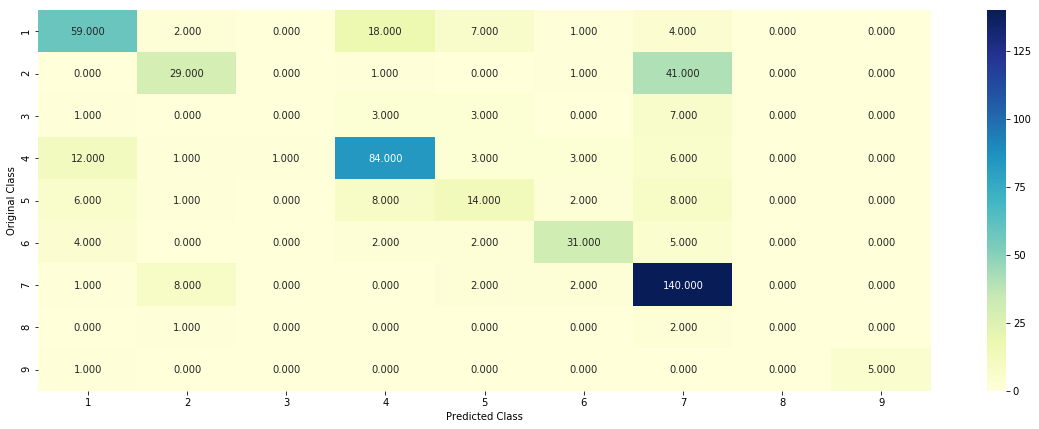

-------------------- Precision matrix (Columm Sum=1) --------------------


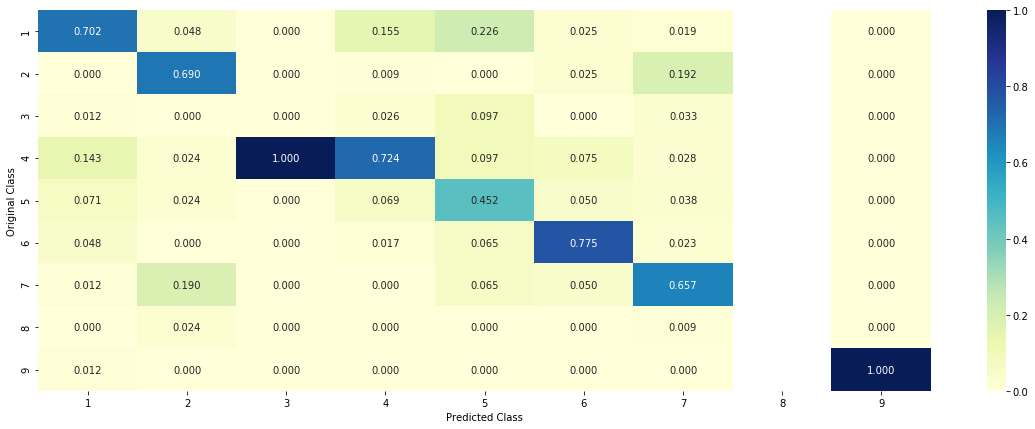

-------------------- Recall matrix (Row sum=1) --------------------


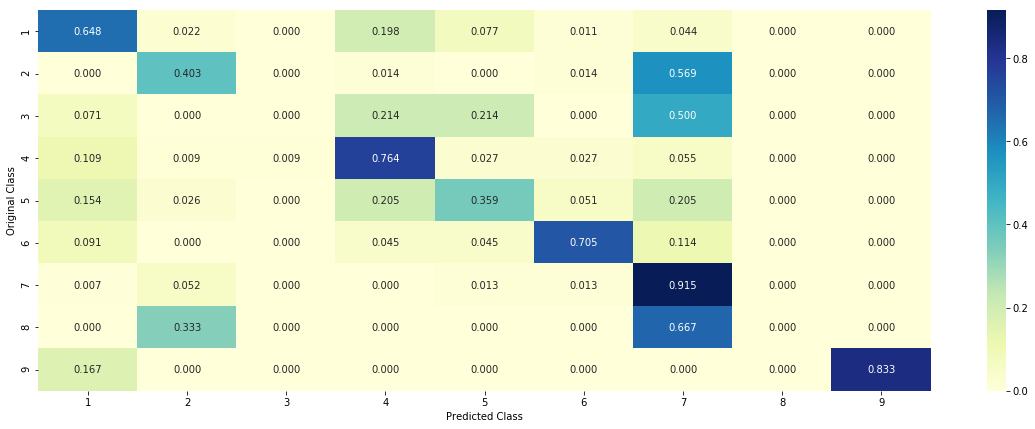

In [153]:
#Testing the model with best hyper paramters

clf = LogisticRegression(C=alpha[best_alpha], penalty='l2', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf, y_train, cv_x_tfidf, y_cv, clf)

#### Observation:

For tfidf (unigram and bigram with class balancing), the Logistic model has been applied above.

It resulted in 0.35 log-loss for training-set, 0.98 log-loss for CV data and 0.96 for test-set. 

But classes, with less number of values, have suffered again as they are not involved in precision and recall matrix.

Results are better than Naive Bayed or KNN model and equivalent to Logistic Regression with BoW.

### Logistic Regression with Onehot Encoding with balanced class


for alpha = 1e-06
Log Loss : 1.3093354455727875

for alpha = 1e-05
Log Loss : 1.344670777797204

for alpha = 0.0001
Log Loss : 1.2624750377971106

for alpha = 0.001
Log Loss : 1.1133424526167854

for alpha = 0.01
Log Loss : 1.1471461318824627

for alpha = 0.1
Log Loss : 1.440540252290796

for alpha = 1
Log Loss : 1.6667964789135736

for alpha = 10
Log Loss : 1.6957438147174522

for alpha = 100
Log Loss : 1.6987545858231214


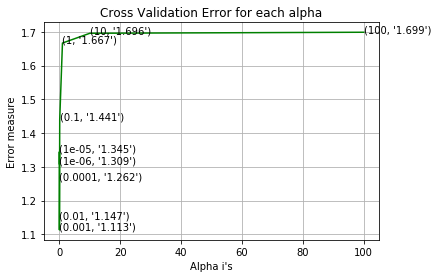

For values of best alpha =  0.001 The train log loss is: 0.5727049626523608
For values of best alpha =  0.001 The cross validation log loss is: 1.1133424526167854
For values of best alpha =  0.001 The test log loss is: 1.1128039556993254


In [155]:
#Hyper paramter tuning

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("\nfor alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

Log loss : 1.1133424526167854
Number of mis-classified points : 0.3458646616541353
-------------------- Confusion matrix --------------------


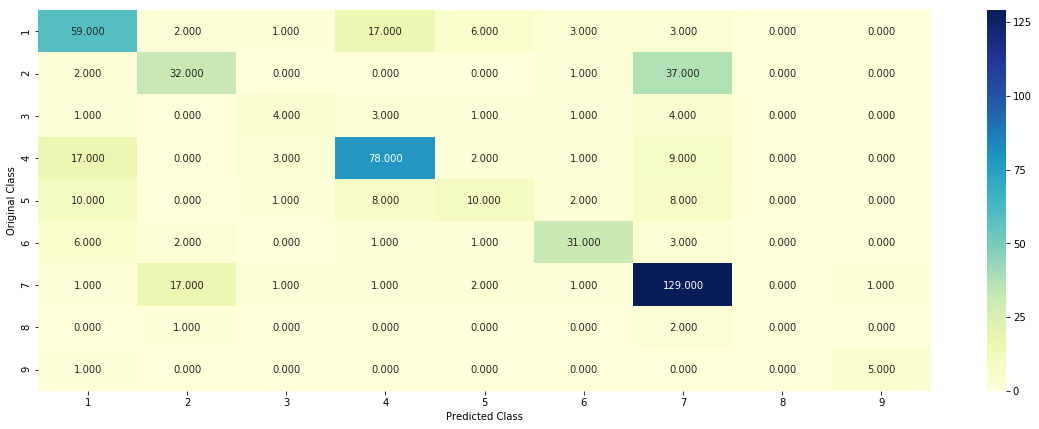

-------------------- Precision matrix (Columm Sum=1) --------------------


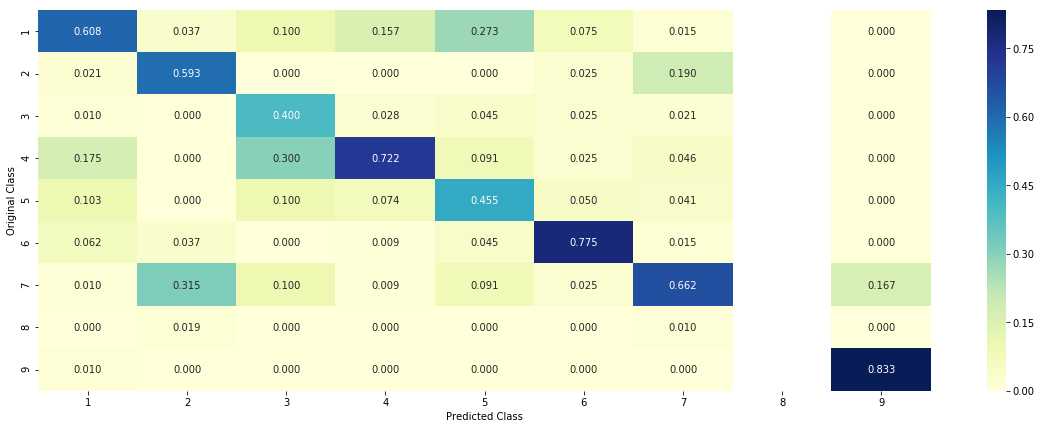

-------------------- Recall matrix (Row sum=1) --------------------


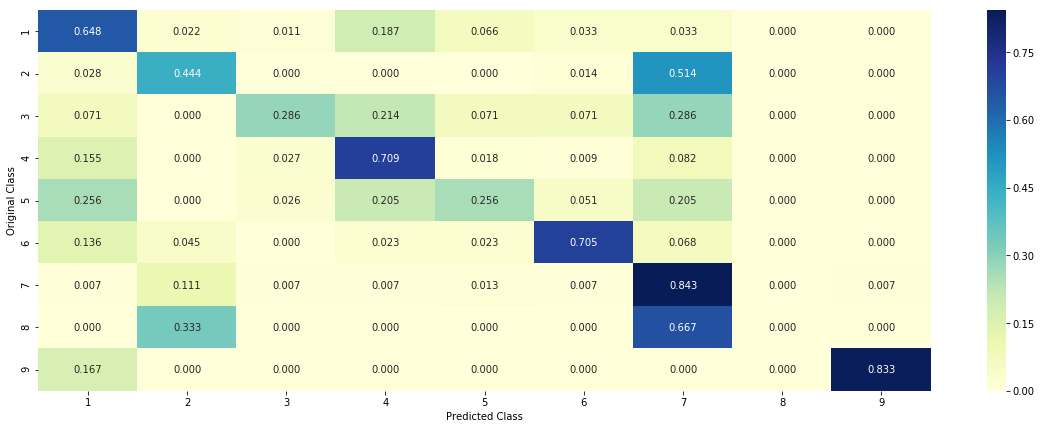

In [156]:
#Testing the model with best hyper paramters

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### Observation:

For onehotCoding (with class balancing), the Logistic model has been applied above.

It resulted in 0.57 log-loss for training-set, 1.11 log-loss for CV data and 1.11 for test-set. 

But classes, with less number of values, have suffered again as they are not involved in precision and recall matrix.

Results are not better than tfidf or BoW model with class balancing. 

In [157]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [158]:
#Correctly Classified point
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
#get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.     0.3226 0.     0.     0.     0.     0.6766 0.0008 0.    ]]
Actual Class : 7
--------------------------------------------------


In [159]:
#Incorrectly Classified point
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
#get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5222 0.0189 0.0055 0.0785 0.3474 0.0012 0.0204 0.0031 0.0029]]
Actual Class : 5
--------------------------------------------------


### Logistic Regression with Onehot Encoding and without balanced class 


for alpha = 1e-06
Log Loss : 1.2957296732654613

for alpha = 1e-05
Log Loss : 1.3060858854780903

for alpha = 0.0001
Log Loss : 1.2624361745047632

for alpha = 0.001
Log Loss : 1.1480795839108977

for alpha = 0.01
Log Loss : 1.2045650699580395

for alpha = 0.1
Log Loss : 1.329239713709686

for alpha = 1
Log Loss : 1.6103521613522607


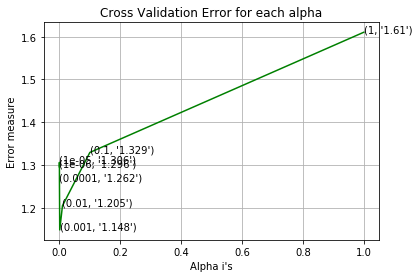

For values of best alpha =  0.001 The train log loss is: 0.5688670769710756
For values of best alpha =  0.001 The cross validation log loss is: 1.1480795839108977
For values of best alpha =  0.001 The test log loss is: 1.124399904343643


In [160]:
#Hyper paramter tuning

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("\nfor alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

Log loss : 1.1480795839108977
Number of mis-classified points : 0.3458646616541353
-------------------- Confusion matrix --------------------


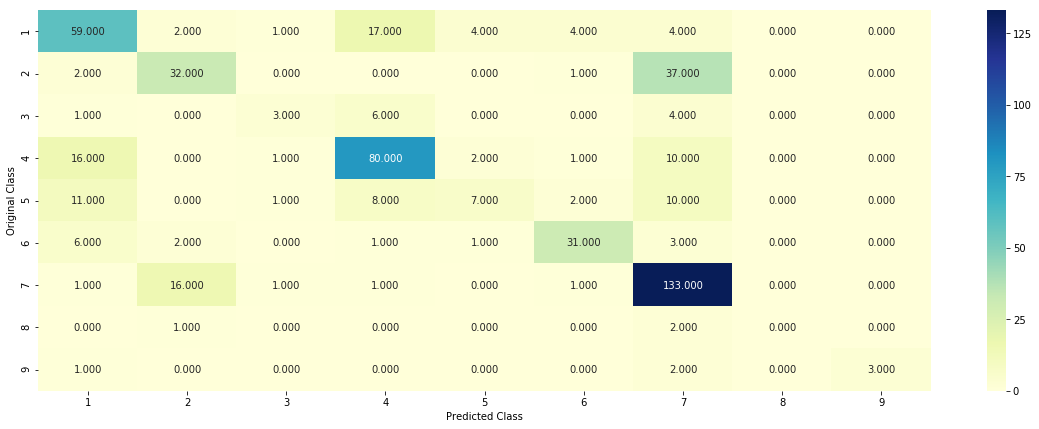

-------------------- Precision matrix (Columm Sum=1) --------------------


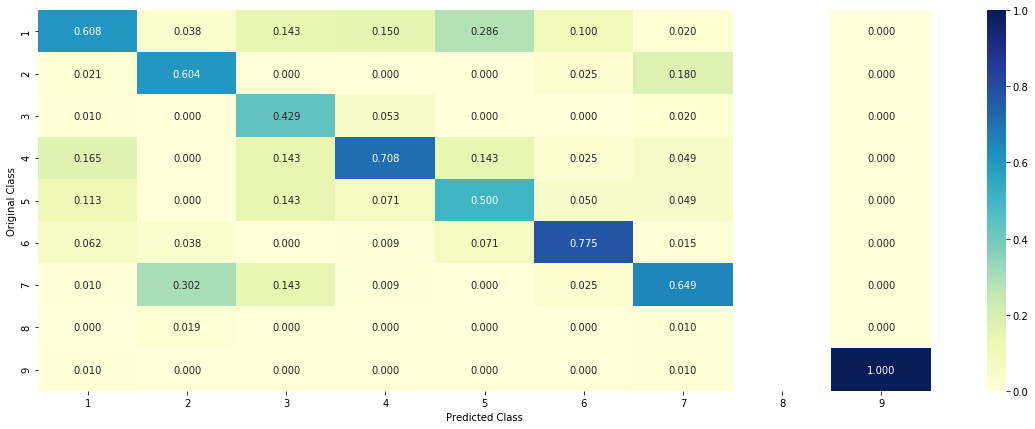

-------------------- Recall matrix (Row sum=1) --------------------


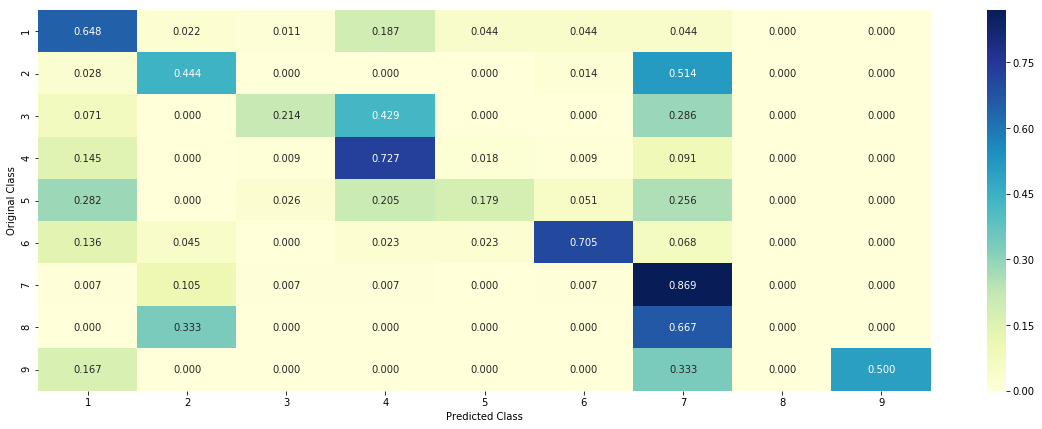

In [161]:
#Testing model with best hyper parameters

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### Observation:

For onehotCoding (without class balancing), the Logistic model has been applied above.

It resulted in 0.57 log-loss for training-set, 1.15 log-loss for CV data and 1.12 for test-set. 

But classes, with less number of values, have suffered again as they are not involved in precision and recall matrix.

Results are not better than tfidf or BoW model. 

In [162]:
#Feature Importance, Correctly Classified point

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
#get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.     0.3168 0.     0.     0.     0.     0.6818 0.0013 0.    ]]
Actual Class : 7
--------------------------------------------------


In [163]:
#Feature Importance, Inorrectly Classified point

test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
#get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5244 0.0206 0.0029 0.0971 0.3256 0.0012 0.024  0.0024 0.0017]]
Actual Class : 5
--------------------------------------------------


## Linear Support Vector Machines 


for C = 1e-05
Log Loss : 1.332740044096075

for C = 0.0001
Log Loss : 1.3119746019180367

for C = 0.001
Log Loss : 1.2153447644312945

for C = 0.01
Log Loss : 1.1560991922644934

for C = 0.1
Log Loss : 1.3534285959559893

for C = 1
Log Loss : 1.6857551406256932

for C = 10
Log Loss : 1.6991997987392908

for C = 100
Log Loss : 1.6991997196236994


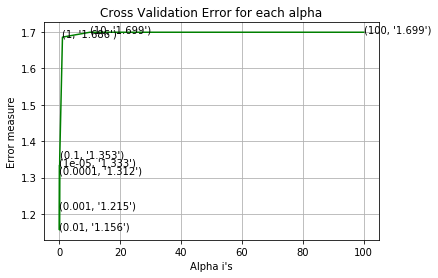

For values of best alpha =  0.01 The train log loss is: 0.712267445965955
For values of best alpha =  0.01 The cross validation log loss is: 1.1560991922644934
For values of best alpha =  0.01 The test log loss is: 1.1380111827356068


In [164]:
#Hyper paramter tuning

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("\nfor C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

Log loss : 1.1560991922644934
Number of mis-classified points : 0.37030075187969924
-------------------- Confusion matrix --------------------


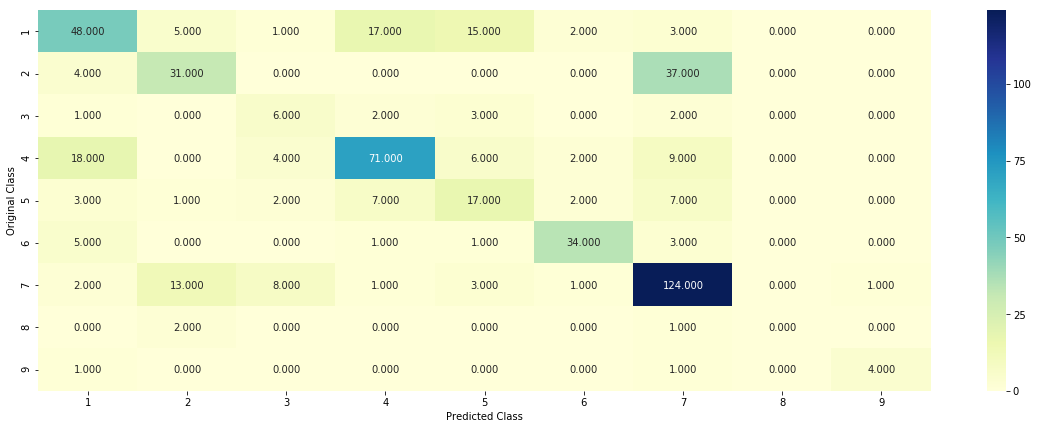

-------------------- Precision matrix (Columm Sum=1) --------------------


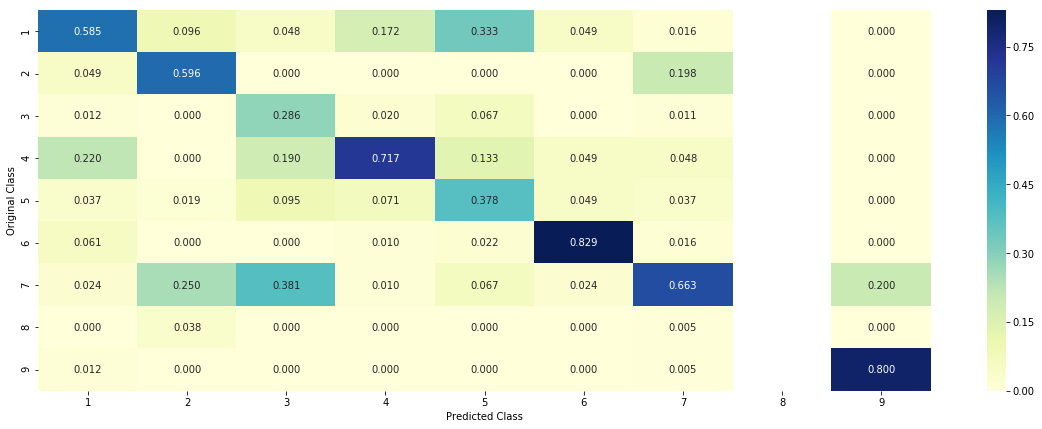

-------------------- Recall matrix (Row sum=1) --------------------


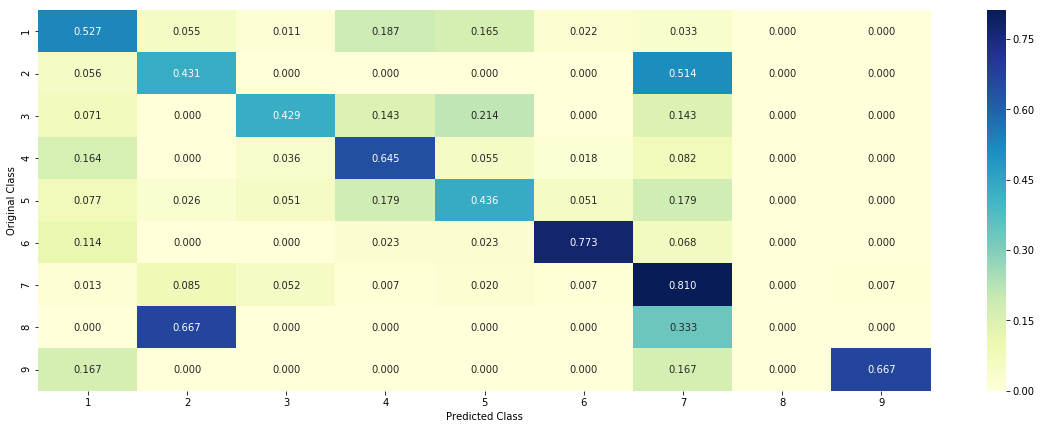

In [165]:
#Testing model with best hyper parameters

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

#### Observation:

For onehotCoding (with class balancing), Linear SVM model has been applied above.

It resulted in 0.71 log-loss for training-set, 1.16 log-loss for CV data and 1.14 for test-set. 

But classes, with less number of values, have suffered again as they are not involved in precision and recall matrix.

Results are not better than tfidf or BoW model. 

In [166]:
#For Correctly classified point

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
#get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[5.000e-04 3.441e-01 1.000e-04 1.300e-03 3.000e-04 4.000e-04 6.518e-01
  1.100e-03 3.000e-04]]
Actual Class : 7
--------------------------------------------------


In [167]:
#For Incorrectly classified point

test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
#get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.4676 0.0425 0.0098 0.0724 0.3331 0.001  0.0639 0.0052 0.0045]]
Actual Class : 5
--------------------------------------------------


## Random Forest Classifier 

In [168]:
#Hyper paramter tuning (With One hot Encoding)

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("\nfor n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y))


for n_estimators = 100 and max depth =  5
Log Loss : 1.2133142102474326

for n_estimators = 100 and max depth =  10
Log Loss : 1.1376100498872552

for n_estimators = 200 and max depth =  5
Log Loss : 1.1955113774864436

for n_estimators = 200 and max depth =  10
Log Loss : 1.1327749551711424

for n_estimators = 500 and max depth =  5
Log Loss : 1.1881065020816732

for n_estimators = 500 and max depth =  10
Log Loss : 1.1241302696791635

for n_estimators = 1000 and max depth =  5
Log Loss : 1.1896240735230224

for n_estimators = 1000 and max depth =  10
Log Loss : 1.1228903843843359

for n_estimators = 2000 and max depth =  5
Log Loss : 1.188096418655168

for n_estimators = 2000 and max depth =  10
Log Loss : 1.1227799355482606
For values of best estimator =  2000 The train log loss is: 0.6873954778801096
For values of best estimator =  2000 The cross validation log loss is: 1.1227799355482608
For values of best estimator =  2000 The test log loss is: 1.1290006586917964


Log loss : 1.1227799355482608
Number of mis-classified points : 0.36466165413533835
-------------------- Confusion matrix --------------------


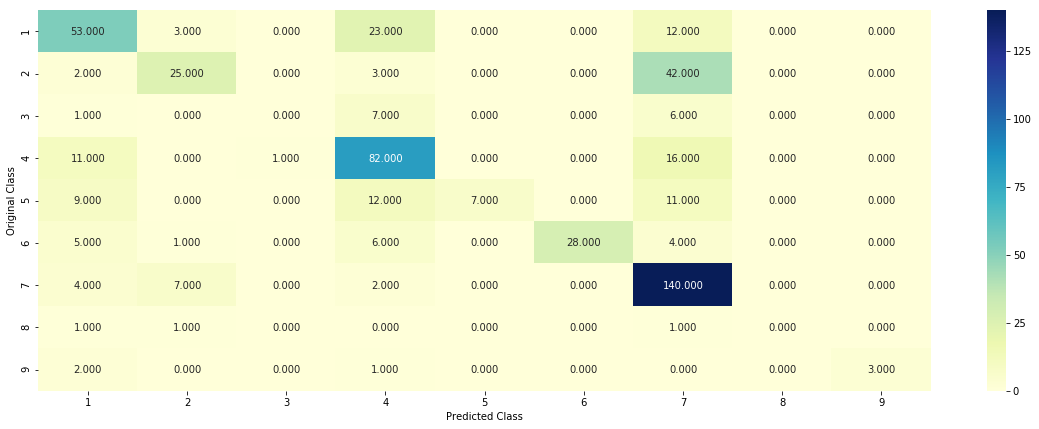

-------------------- Precision matrix (Columm Sum=1) --------------------


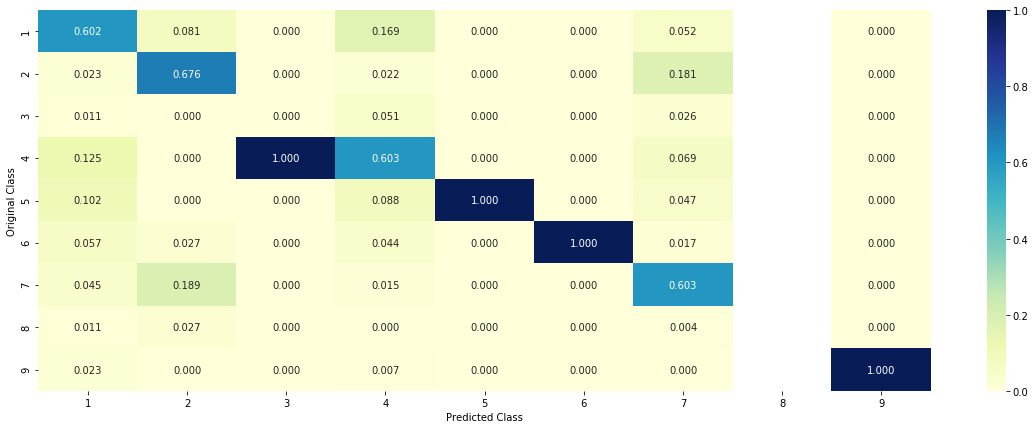

-------------------- Recall matrix (Row sum=1) --------------------


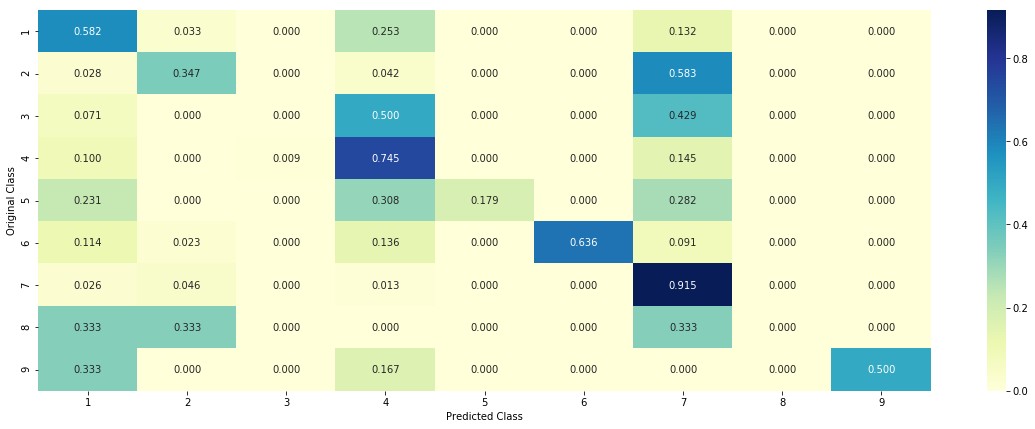

In [169]:
#Testing model with best hyper parameters (One Hot Encoding)

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

#### Observation:

For onehotCoding, the Random Forest model has been applied above.

It resulted in 0.68 log-loss for training-set, 1.12 log-loss for CV data and 1.13 for test-set. 

But classes, with less number of values, have suffered again as they are not involved in precision and recall matrix.

Results are not better than tfidf or BoW model.

In [170]:
#Feature Importance: Correctly Classified point

# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
#get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0288 0.147  0.0125 0.0257 0.0309 0.0247 0.7236 0.0032 0.0036]]
Actual Class : 7
--------------------------------------------------


In [171]:
#Feature Importance: Inorrectly Classified point

test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
#get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.6028 0.0155 0.0172 0.1267 0.1654 0.0462 0.0177 0.0044 0.004 ]]
Actuall Class : 5
--------------------------------------------------


## Random Forest with Response  Coding

In [172]:
#Hyper paramter tuning (With Response Coding)

alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("\nfor n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y))


for n_estimators = 10 and max depth =  2
Log Loss : 2.148373003682518

for n_estimators = 10 and max depth =  3
Log Loss : 1.7627615227633564

for n_estimators = 10 and max depth =  5
Log Loss : 1.456515586564994

for n_estimators = 10 and max depth =  10
Log Loss : 1.7749649776144307

for n_estimators = 50 and max depth =  2
Log Loss : 1.7907865426265763

for n_estimators = 50 and max depth =  3
Log Loss : 1.5197837736771966

for n_estimators = 50 and max depth =  5
Log Loss : 1.4137171515276632

for n_estimators = 50 and max depth =  10
Log Loss : 1.637408524502975

for n_estimators = 100 and max depth =  2
Log Loss : 1.6514341911034514

for n_estimators = 100 and max depth =  3
Log Loss : 1.55516230908919

for n_estimators = 100 and max depth =  5
Log Loss : 1.3589848507706241

for n_estimators = 100 and max depth =  10
Log Loss : 1.6524603467896442

for n_estimators = 200 and max depth =  2
Log Loss : 1.697568538932858

for n_estimators = 200 and max depth =  3
Log Loss : 1.556080

Log loss : 1.3589848507706241
Number of mis-classified points : 0.4567669172932331
-------------------- Confusion matrix --------------------


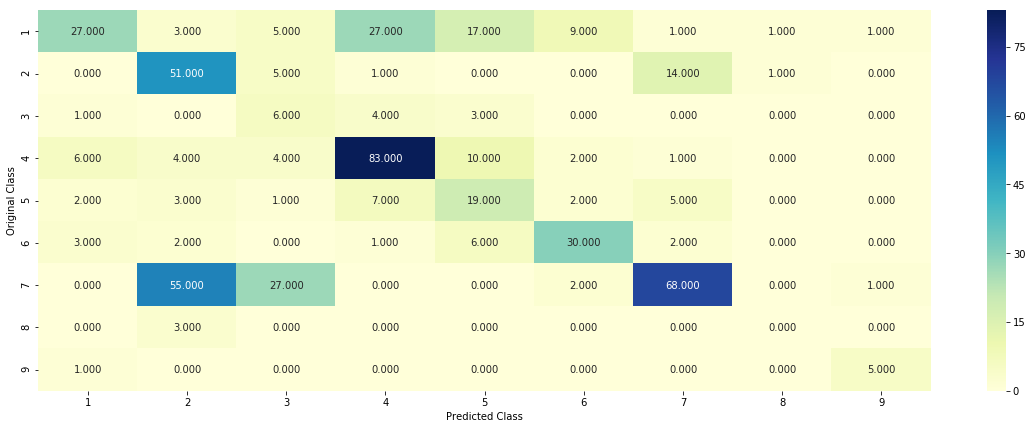

-------------------- Precision matrix (Columm Sum=1) --------------------


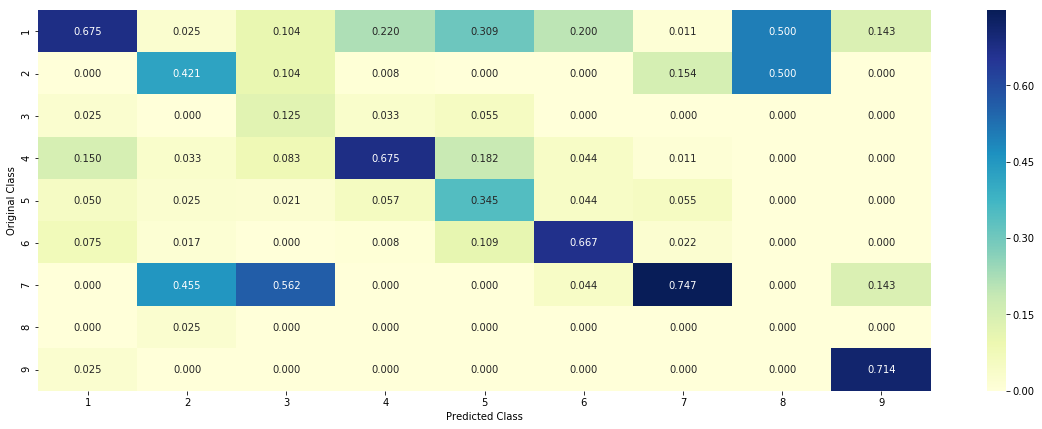

-------------------- Recall matrix (Row sum=1) --------------------


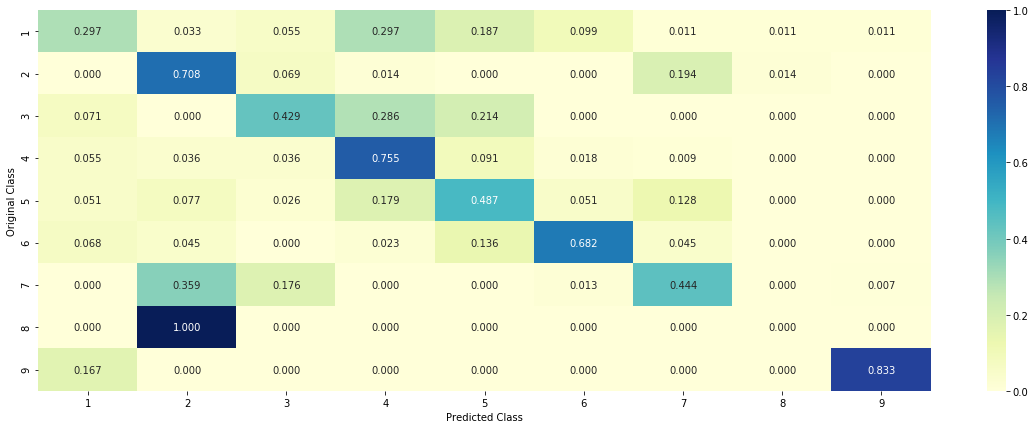

In [173]:
#Testing model with best hyper parameters (Response Coding)

clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

#### Observation:

For responseCoding, the Random Forest model has been applied above.

It resulted in 0.52 log-loss for training-set, 1.25 log-loss for CV data and 1.24 for test-set. 

But classes, with less number of values, have suffered again as they are not involved in precision and recall matrix.

Results are not better than tfidf or BoW model.

In [174]:
#Feature Importance: Correctly Classified point

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0071 0.5364 0.1231 0.017  0.0322 0.027  0.2241 0.0231 0.01  ]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Gene is important feature


In [175]:
#Feature Importance: InCorrectly Classified point

test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 5
Predicted Class Probabilities: [[0.0268 0.0043 0.0169 0.023  0.6595 0.2584 0.0025 0.0044 0.0041]]
Actual Class : 5
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Gene is important feature


## Stacked Model

In [176]:
#testing with hyper parameter tuning

clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.12
Support vector machines : Log Loss: 1.69
Naive Bayes : Log Loss: 1.29
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.040
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.526
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.131
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.239
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.505


Log loss (train) on the stacking classifier : 0.6498302469206114
Log loss (CV) on the stacking classifier : 1.1311077921131338
Log loss (test) on the stacking classifier : 1.1595792179100746
Number of missclassified point : 0.3879699248120301
-------------------- Confusion matrix --------------------


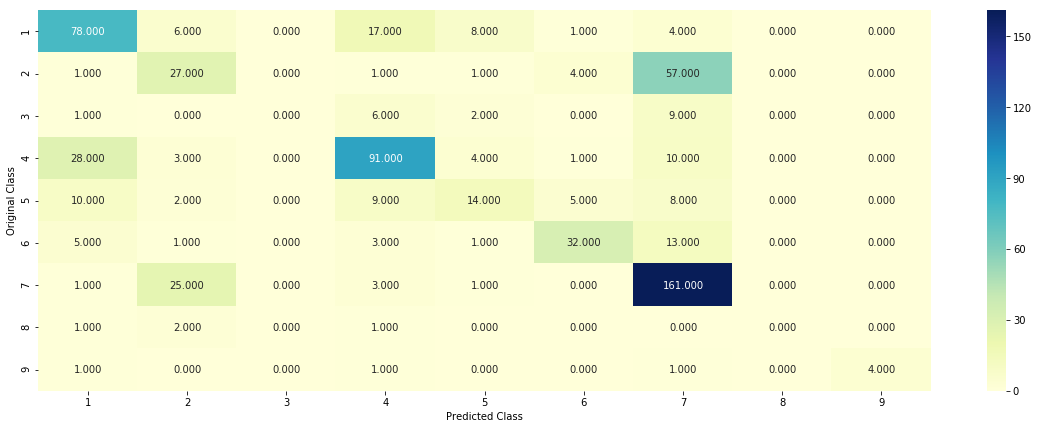

-------------------- Precision matrix (Columm Sum=1) --------------------


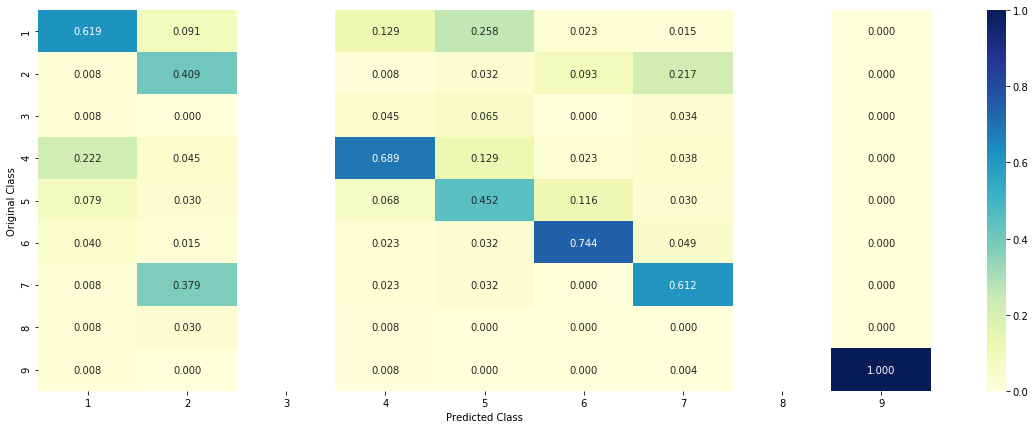

-------------------- Recall matrix (Row sum=1) --------------------


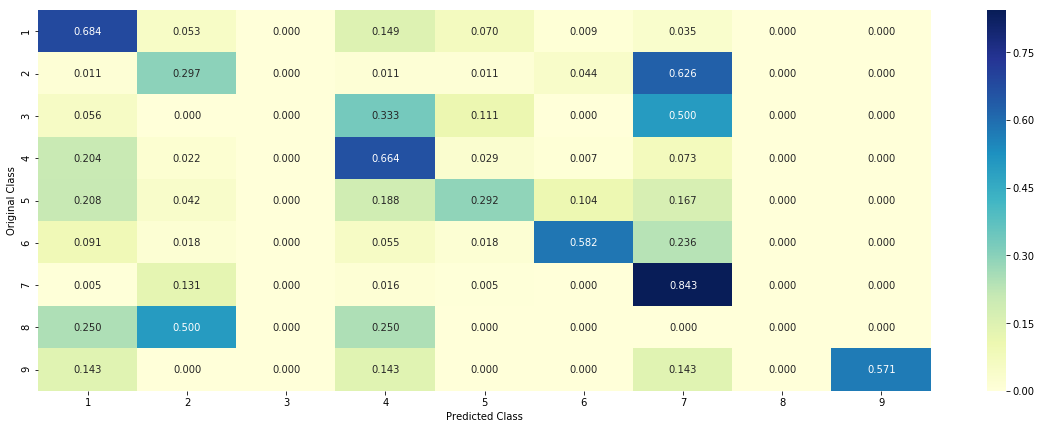

In [177]:
#testing the model with the best hyper parameters

lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

#### Observation:

For onehotCoding, stacked model has been applied above.

It resulted in 0.64 log-loss for training-set, 1.13 log-loss for CV data and 1.15 for test-set. 

But classes, with less number of values, have suffered again as they are not involved in precision and recall matrix.

Results are not better than tfidf or BOW model.

### Maximum Voting Classifier 

Log loss (train) on the VotingClassifier : 0.9076965054343864
Log loss (CV) on the VotingClassifier : 1.2071473560724522
Log loss (test) on the VotingClassifier : 1.2104439027495066
Number of missclassified point : 0.37293233082706767
-------------------- Confusion matrix --------------------


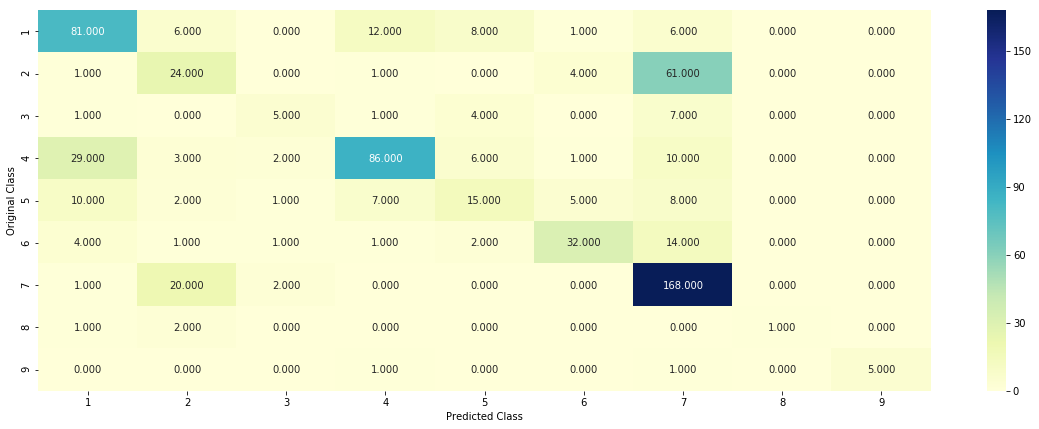

-------------------- Precision matrix (Columm Sum=1) --------------------


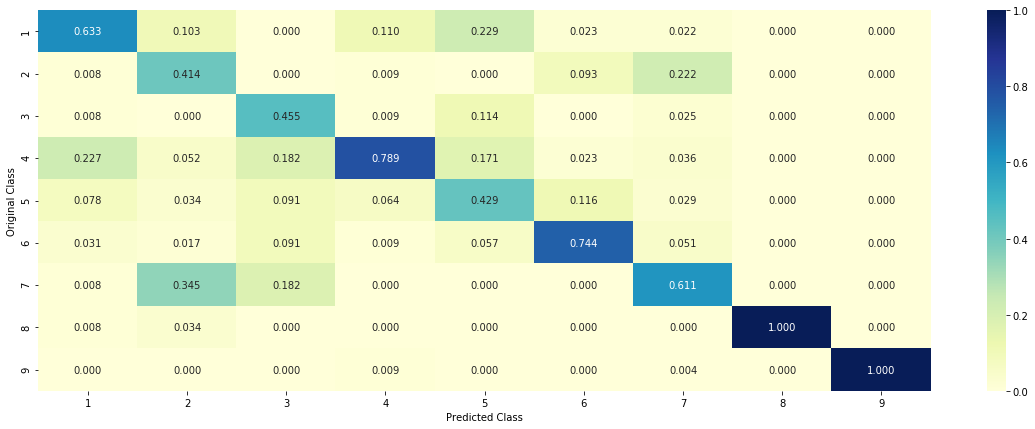

-------------------- Recall matrix (Row sum=1) --------------------


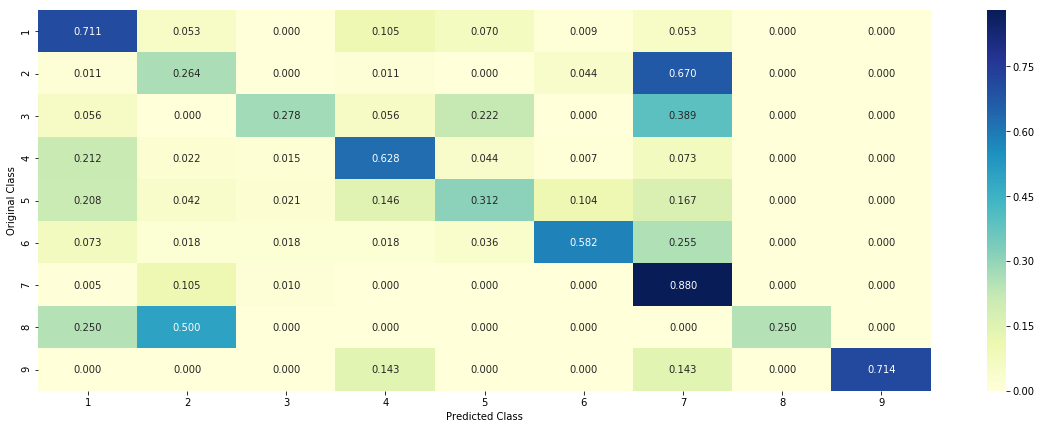

In [178]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

#### Observation:

For onehotCoding, maximum voting model has been applied above.

It resulted in 0.90 log-loss for training-set, 1.2 log-loss for CV data and 1.21 for test-set. 

But classes, with less number of values, have suffered again as they are not involved in precision and recall matrix.

Results are not better than tfidf or BOW model. 

In [200]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Models\Paramters","Train Loss", "CV Loss", "Test Loss", "Miss-Classified"]

x.add_row(["Random Model: ", "2.4626077277382987" , 2.504215471251153 ,2.489917832146807,"0.8857142857142857\n"])
x.add_row(["Univa Analy 'Gene'(LR+Calib.)","1.0252136649004921", "1.1963352658106332","1.216614607567022","0.9428571428571428"])
x.add_row(["UniV Analy 'Variation'(LR+Calib.)","0.7111023558122576", "1.7322365300209561","1.6934299709367888","0.9142857142857143"])

x.add_row(["UniV Analy 'Text'(tfidf+1HotEncod)","0.7001371701802732", "1.1870662728628807","1.1973329448493666","0.968421052631579\n"])
x.add_row(["Naive Bayes ","0.9151887243795561", "1.2679414209037072","1.2949910047717403","0.3815789473684211"])

x.add_row(["K-Nearest Neighbour ","0.6838789439284688", "1.0925676027867914","1.1145938485283275","0.37593984962406013\n"])

x.add_row(["Log Regre (BoW-Bal. Class) ","0.3533032245749473", "0.9820765457740601","0.9626411888138315","0.325187969924812"])
x.add_row(["Log Reg.(BoW-w/o Bal. Class) ","0.3522104206219732", "0.9824376470582592","0.9633440215559156","0.325187969924812\n"])

x.add_row(["Log Regre (tfidf-Bal. Class) ","0.35301532769444927", "0.9790087470396699","0.961787335809495","0.32142857142857145"])
x.add_row(["Log Reg.(tfidf-w/o Bal. Class) ","0.35211357449668595", "0.9792653584067594","0.962320744265082","0.31954887218045114\n"])

x.add_row(["Log Reg. (1HotEncode-Bal. Class) ","0.5727049626523608", "1.1133424526167854","1.1128039556993254","0.3458646616541353"])
x.add_row(["Log Reg.(1HotEncode-w/o Bal. Class) ","0.5688670769710756", "1.1480795839108977","1.124399904343643","0.3458646616541353\n"])

x.add_row(["Linear SVM ","0.712267445965955", "1.1560991922644934","1.1380111827356068","0.37030075187969924"])
x.add_row(["Random Forest(1HotEncoding) ","0.6873954778801096", "1.1227799355482608","1.1290006586917964","0.36466165413533835"])

x.add_row(["Random Forest(Response Code) ","0.055339268402244554", "1.3589848507706241","1.34328846636839","0.4567669172932331\n"])
x.add_row(["Stacked Model(LR+SVM+NB) ","0.6498302469206114", "1.1311077921131338","1.1595792179100746","0.3879699248120301"])
x.add_row(["Maximum Voting ",0.9076965054343864, "1.2071473560724522","1.2104439027495066","0.37293233082706767"])

print(x)

+--------------------------------------+----------------------+--------------------+--------------------+---------------------+
|           Models\Paramters           |      Train Loss      |      CV Loss       |     Test Loss      |   Miss-Classified   |
+--------------------------------------+----------------------+--------------------+--------------------+---------------------+
|            Random Model:             |  2.499615818487224   | 2.447143428512841  | 2.5069454835577716 |  0.8872180451127819 |
|                                      |                      |                    |                    |                     |
|    Univa Analy 'Gene'(LR+Calib.)     |  1.0344791998080038  | 1.2263625169777237 | 1.2561123021905696 |  0.9593984962406015 |
|  UniV Analy 'Variation'(LR+Calib.)   |  1.0467179237334998  | 1.7084074341627875 | 1.7187870123341769 |  0.9142857142857143 |
|  UniV Analy 'Text'(tfidf+1HotEncod)  |  0.7001371701802732  | 1.1870662728628807 | 1.1973329448493666 

## Observations

First of all the variants of the data was analysed and we found that there are three features to consider, namely: Gene, variation and Text. 

Gene contains all the types of genes and variation contains all the variation in genes that can be resposible for a particular type of cancer. Text contains some medical teminologies about a particular gene and it's variation.

Then, we preprocessed the data, which includes removing of stop words and checking for any NaN or empty fields. Then, we distributed the data and ploted hostograms, PDFs and CDFsto see the distribution of data in training, CV and test data. 

Then we've taken Random model as base model to judge the performance of other models with log-loss as performance matrix because of the business requirements. Here, we want to know the probability of belonging to each class for every data point.

Then, we have done univariate analysis of each gene, variation and text features. We have plotted histogram and T-SNE and have applied Logistic Regression on each alone features. We've used One hot encoding, response coding, BoWs and TF-IDF of all the three features.

Then we've applied different models to see their performance which we have summarized in the above table. Our aim was to minimize log-loss to below one, which we have achieved in case of Logistic Regression with BoWs and TF-IDF (with both balanced and unbalanced class) with unigram and bigrams.